# Business Understanding

Loan approval prediction is to predict whether the new loan application from new applicants should be rejected or approved. 




In [1]:
!pip install --upgrade pip
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(font_scale=1)
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

#import warnings to surpress warnings

import warnings
warnings.filterwarnings("ignore")

# 1. Data Understanding

In [4]:
# Initializing dataset
df = pd.read_csv("loan_data_2007_2014.csv", index_col=0)
print(f'\n Shape of the Dataset: {df.shape[0]} rows and {df.shape[1]} columns')
df.head(5)


 Shape of the Dataset: 466285 rows and 74 columns


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Understand the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13  annu

In [5]:
#Checking the shape of the dataframe
df.shape
print(f'row : {df.shape[0]}')
print(f'column : {df.shape[1]}')

# Exploring the descriptive statistics of the dataframe
df.describe().T

row : 466285
column : 74


,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


# 2. Exploratory Data Analysis

- Numerical and categorical features
- Data Cleaning
- Imbalanced data and outliers

## 2.1 Numerical & Categorical Features

In [6]:
# Separate numerical & categorical feature columns
numerical = df.select_dtypes (include = ['int64', 'float64'])
categorical = df.select_dtypes (include = 'object')

#Convert columns to list
numerical_col = numerical.columns.to_list()
categorical_col = categorical.columns.to_list()

### 2.1.1 Numerical Features

In [7]:
# Explore numerical features' descriptive
print(f'rows: {numerical.shape[0]}')
print (f'columns: {numerical.shape[1]}')

numerical.describe().T


rows: 466285
columns: 52


,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


### 2.1.2 Categorical Features

In [8]:
#Exploring the categorical features' descriptive

print (f'rows: {categorical.shape[0]}')
print (f'columns: {categorical.shape[1]}')

categorical.describe().T

rows: 466285
columns: 22


,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276


## 2.2 Data Cleaning

Checking and handling:
- Duplicate values
- Missing values
- Irrelevant Features
- Data leakage
- Uninformative features

### 2.2.1 Duplicate Values

In [22]:
# Checking and removing duplicates in the dataset
df.duplicated().sum()

np.int64(0)

No duplicate values

### 2.2.2 Missing Values

In [11]:
#checking the total missing values in each feature
sum_null = df.isnull().sum()

# Calculate the percentage of the missing values in each feature
missing_percent = (sum_null*100)/len(df)

# Checking the data type for each feature
data_type= [df[col].dtype for col in df.columns]

# Create a new dataframe for the missing value
data_isnull = pd.DataFrame({"total_null": sum_null, "data_type": data_type, "missing_%": missing_percent})

#sort the percentage of missing values from the largest to the lowest
data_isnull.sort_values("missing_%", ascending = False, inplace = True)

#display the missing value dataframe
data_isnull_sort = data_isnull[data_isnull["missing_%"]>0].reset_index()
data_isnull_sort

,index,total_null,data_type,missing_%
0,open_rv_24m,466285,float64,100.000000
1,inq_fi,466285,float64,100.000000
2,open_rv_12m,466285,float64,100.000000
3,il_util,466285,float64,100.000000
4,mths_since_rcnt_il,466285,float64,100.000000
5,total_bal_il,466285,float64,100.000000
6,open_il_24m,466285,float64,100.000000
7,open_il_12m,466285,float64,100.000000
8,open_il_6m,466285,float64,100.000000
9,open_acc_6m,466285,float64,100.000000


#### Handling Missing Values

##### a. Dropping 50% missing values

There are 21 columns that have more than 50% missing values. Thus, they are dropped from the dataframe

In [12]:
# Drop features with missing value ≥ 50%

col_null = data_isnull.loc[data_isnull["missing_%"]>=50].index.tolist()
df.drop(columns = col_null, inplace = True)

In [13]:
df.shape
print(f'row : {df.shape[0]}')
print(f'column : {df.shape[1]}')
print(f'numericals_features : {df.select_dtypes(include=["int64", "float64"]).shape[1]}')
print (f'categorical_features : {df.select_dtypes(include = "object").shape[1]}')
df.head()

row : 466285
column : 53
numericals_features : 32
categorical_features : 21


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN


##### b. Replacing Missing Values with 0

There are features with missing values that can be replaced with 0:

- tot_coll_amt	 = Total collection amounts ever owed -> assumption: customers don't borrow.
- tot_cur_bal	     = Total current balance of all accounts  -> assumption: customers don't have any current balance.
- total_rev_hi_lim = Total revolving high credit/credit limit -> assumption: customers don't have a revolving limit.

In [14]:
# Replacing the selected features with missing values with 0

for item in ["tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim"]:
    df[item] = df[item].fillna(0)

df[['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']].head(3)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0


##### c. Handling missing values in numerical features

Since the numerical features are in continuous values, the median of each of these features is used to replace the missing values

In [15]:
# Replacing the missing values in numerical features with median
numericals = df.select_dtypes(include=['int64', 'float64'])
for item in numericals:
    df[item] = df[item].fillna(df[item].median())
    
print(f'numerical_features : {df.select_dtypes(include=["int64", "float64"]).shape[1]}')
numericals.head(3)

numerical_features : 32


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,171.62,0.0,1,0.0,0.0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,119.66,0.0,1,0.0,0.0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,649.91,0.0,1,0.0,0.0,0.0,0.0


##### d. Handling missing values in categorical features

The mode of each of categorical features is used to replace the missing values

In [16]:
# Replacing the missing values in categorical features with mode
categoricals = df.select_dtypes(include=['object'])
for item in categoricals:
    df[item] = df[item].fillna(df[item].mode().iloc[0])
    
print(f'categorical_features : {df.select_dtypes(include="object").shape[1]}')
categoricals.head(3)

categorical_features : 21


,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,NaN,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,Apr-99,f,Apr-13,NaN,Sep-13,INDIVIDUAL
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,NaN,Jan-16,INDIVIDUAL


### 2.2.3 Irrelevant Features


There are irrelevant features that don't have any correlation or association with the target features due to their nature of unique entries, no association with the target feature, leading to bias, etc. These features are:

- id = A unique LC assigned ID for the loan listing. -> the unique entries with no association to the target feature
- member_id = A unique LC assigned Id for the borrower member. -> too many unique entries
- grade = LC assigned loan grade -> Instead, using sub_grade since it has more complete information
- emp_title = The job title supplied by the Borrower when applying for the loan -> too many unique entries
- url = URL for the LC page with listing data -> too many unique entries, no association with the target feature
- zip_code = The first 3 numbers of the zip code provided by the borrower in the loan application. -> can lead to bias
- addr_state = The state provided by the borrower in the loan application -> Can lead to bias
- title = The loan title provided by the borrower -> too many unique entries
- inq_last_6mths = The number of inquiries in the past 6 months.
- issue_d = The month in which the loan was funded

In [17]:
# drop the irrelevant features
df.drop(columns =["id","member_id","grade","emp_title","url", 
                       "zip_code", "addr_state","title", 
                       "inq_last_6mths","issue_d"], inplace = True)

### 2.2.4 Data Leakage

There are features are acquired after the loan is approved and are not available by the time when the model is making predictions. Thus, using these feature will lead to data leakage and unrealistic high accuracy during training and test, but poor performance during real-world prediction.

- funded_amnt = The total amount committed to that loan at that point in time.
- funded_amnt_inv = The total amount committed to that loan at that point in time by investor
- out_prncp = Remaining outstanding principal for total amount funded
- out_prncp_inv = Remaining outstanding principal for portion of total amount funded by investors
- total_pymnt = Payments received to date for total amount funded
- total_pymnt_inv = Payments received to date for portion of total amount funded by investors
- total_rec_prncp = Principal received to date
- total_rec_int = Interest received to date
- total_rec_late_fee = Late fees received to date
- recoveries = Indicates if a payment plan has been put in place for the loan
- collection_recovery_fee = post charge off collection fee
- tot_coll_amt = Total collection amounts ever owed
- last_pymnt_amnt = Last total payment amount received
- revol_util = Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.        
- collections_12_mths_ex_med = Number of collections in 12 months excluding medical collections
- last_pymnt_d = Last month's payment was received
- next_pymnt_d = Next scheduled payment date
- last_credit_pull_d = The most recent month LC pulled credit for this loan
- initial_list_status = The initial listing status of the loan. Possible values are – Whole, Fractional
- total_rev_hi_lim = total revolving high credit/credit limit
  

In [18]:
# Drop the data leakage features
df.drop(columns = ['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 
                   'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                   'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                   'tot_coll_amt', 'last_pymnt_amnt', 'revol_util', 'collections_12_mths_ex_med',
                   'last_pymnt_d','next_pymnt_d','last_credit_pull_d','initial_list_status',
                   'total_rev_hi_lim' ], inplace= True)

### 2.2.5 Uniformative Features for Classification

There are categorical features that don't give enough information for classification predictions due to their lack of heterogeneity in values. 

- pymnt_plan = Indicates if a payment plan has been put in place for the loan -> 99.998% has the same value
- policy_code = publicly available policy_code=1, new products not publicly available policy_code=2" -> only 1 unique
- application_type = Indicates whether the loan is an individual application or a joint application with two co-borrowers -> only 1 unique


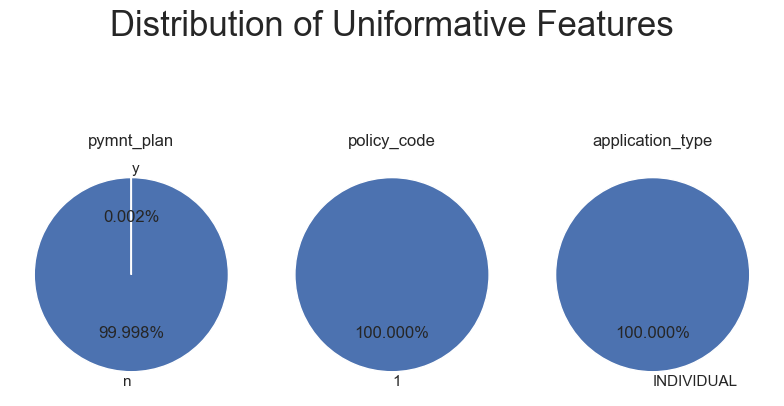

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(8, 5))

# Flatten the axes array to easily iterate
axs = axs.flatten()

# List of features to plot
features = ["pymnt_plan", "policy_code", "application_type"]

# Loop through features and axes
for i, feature in enumerate(features):
    df[feature].value_counts().plot.pie(
        ax=axs[i], 
        autopct='%.3f%%',
        startangle=90,
        ylabel="",  # hide default label
        legend=False
    )
    axs[i].set_title(feature)

# Overall title
fig.suptitle('Distribution of Uniformative Features', fontsize=25)
plt.tight_layout()
plt.show()


Thus, these three features need to be dropped since they bring very little information as features to make predictions

In [20]:
# drop the selected features

df.drop(columns= ["pymnt_plan", "policy_code", "application_type"], inplace = True)

In [21]:
# Checking the latest dataframe

print(f'numericals_features : {df.select_dtypes(include=["int64", "float64"]).shape[1]}')
print (f'categorical_features : {df.select_dtypes(include = "object").shape[1]}')

df.info()

numericals_features : 12
categorical_features : 8
<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            466285 non-null  int64  
 1   term                 466285 non-null  object 
 2   int_rate             466285 non-null  float64
 3   installment          466285 non-null  float64
 4   sub_grade            466285 non-null  object 
 5   emp_length           466285 non-null  object 
 6   home_ownership       466285 non-null  object 
 7   annual_inc           466285 non-null  float64
 8   verification_status  466285 non-null  object 
 9   loan_status          466285 non-null  object 
 10  purpose              466285 non-null  object 
 11  dti                  466285 non-null  float64
 12  delinq_2yrs          466285 non-null  float64
 13  earliest_cr_line     466285 non-null  object 
 14  open_acc             46

## 2.3 Univariate Analysis

### 2.3.1 Numerical Features Univariate Analysis


=== Statistics for loan_amnt ===


Statistic,Value
Minimum,500.0
5-th Percentile,3500.0
Q1,8000.0
Median,12000.0
Q3,20000.0
95-th Percentile,30200.0
Maximum,35000.0
Range,34500.0
IQR,12000.0
Statistic,Value


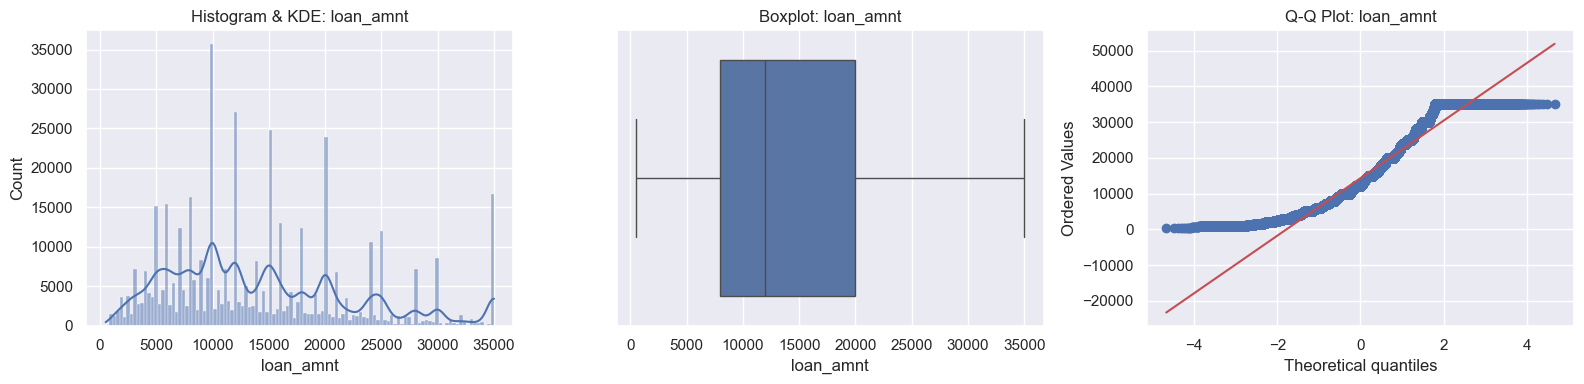


=== Statistics for int_rate ===


Statistic,Value
Minimum,5.42
5-th Percentile,6.99
Q1,10.99
Median,13.66
Q3,16.49
95-th Percentile,21.70
Maximum,26.06
Range,20.64
IQR,5.50
Statistic,Value


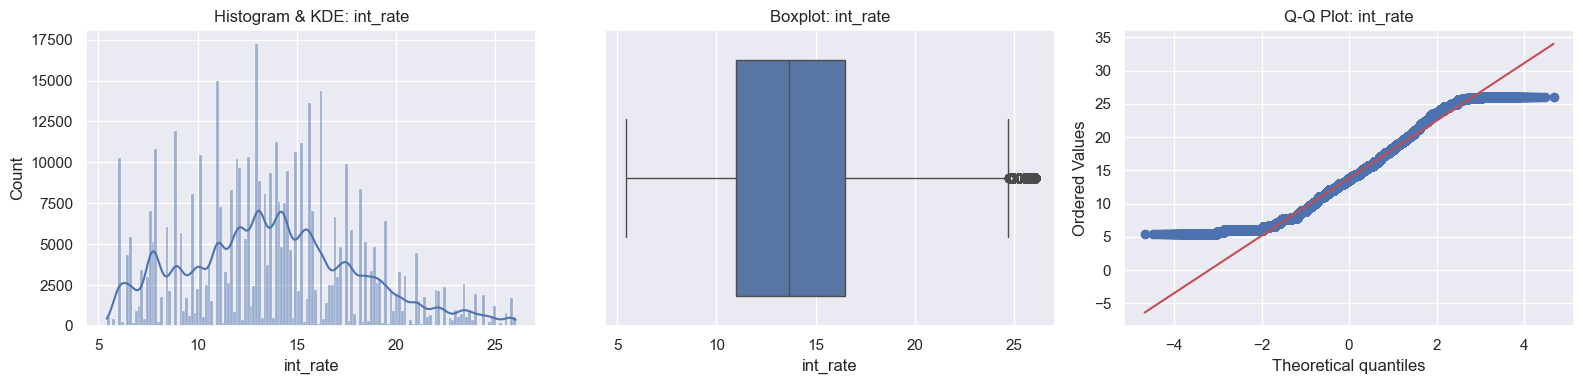


=== Statistics for installment ===


Statistic,Value
Minimum,15.67
5-th Percentile,114.51
Q1,256.69
Median,379.89
Q3,566.58
95-th Percentile,900.93
Maximum,1409.99
Range,1394.32
IQR,309.89
Statistic,Value


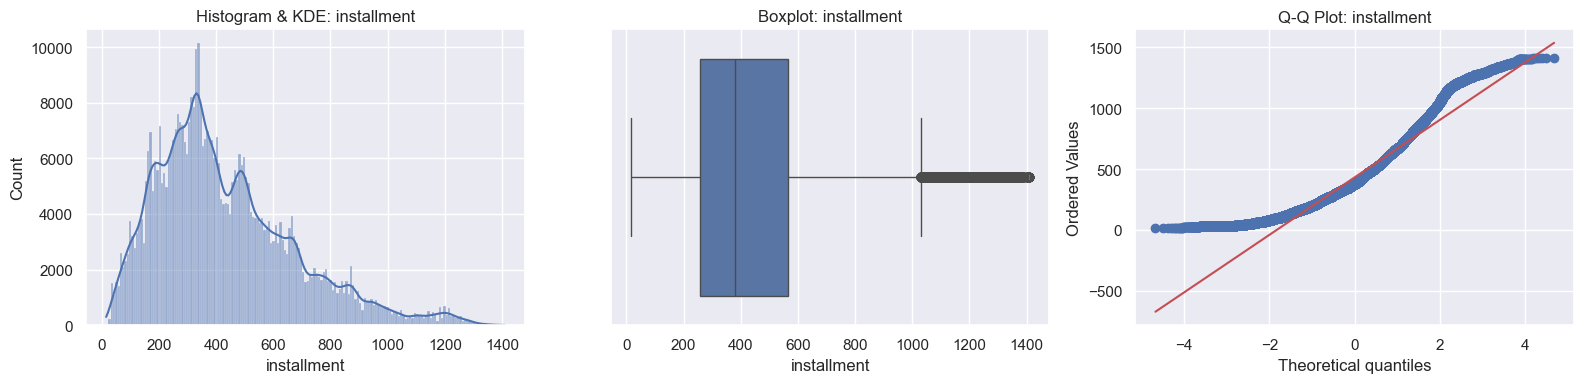


=== Statistics for annual_inc ===


Statistic,Value
Minimum,1896.0
5-th Percentile,28000.0
Q1,45000.0
Median,63000.0
Q3,88953.0
95-th Percentile,150000.0
Maximum,7500000.0
Range,7498104.0
IQR,43953.0
Statistic,Value


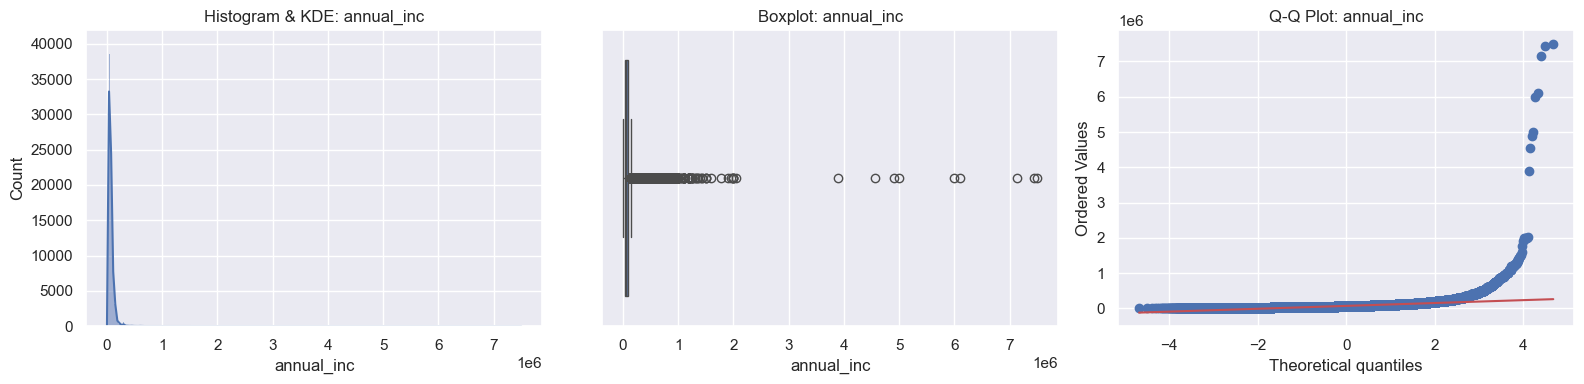


=== Statistics for dti ===


Statistic,Value
Minimum,0.00
5-th Percentile,4.82
Q1,11.36
Median,16.87
Q3,22.78
95-th Percentile,30.77
Maximum,39.99
Range,39.99
IQR,11.42
Statistic,Value


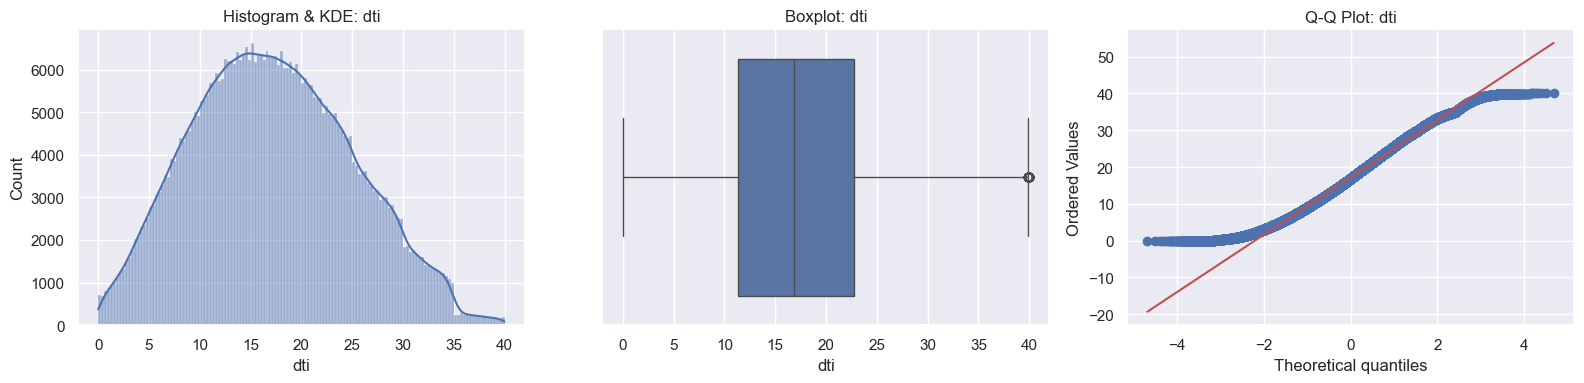


=== Statistics for delinq_2yrs ===


Statistic,Value
Minimum,0.0
5-th Percentile,0.0
Q1,0.0
Median,0.0
Q3,0.0
95-th Percentile,2.0
Maximum,29.0
Range,29.0
IQR,0.0
Statistic,Value


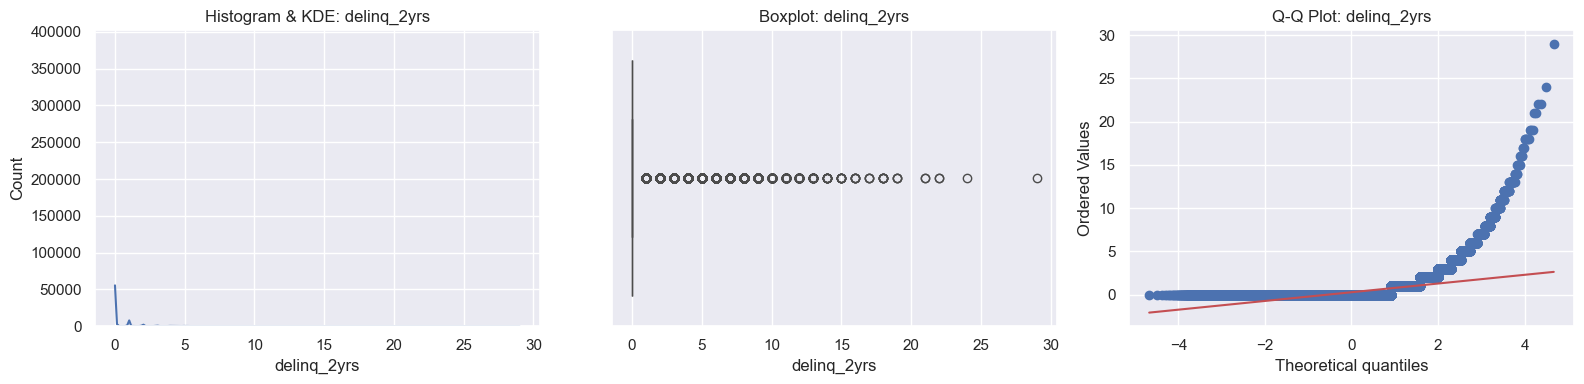


=== Statistics for open_acc ===


Statistic,Value
Minimum,0.0
5-th Percentile,5.0
Q1,8.0
Median,10.0
Q3,14.0
95-th Percentile,20.0
Maximum,84.0
Range,84.0
IQR,6.0
Statistic,Value


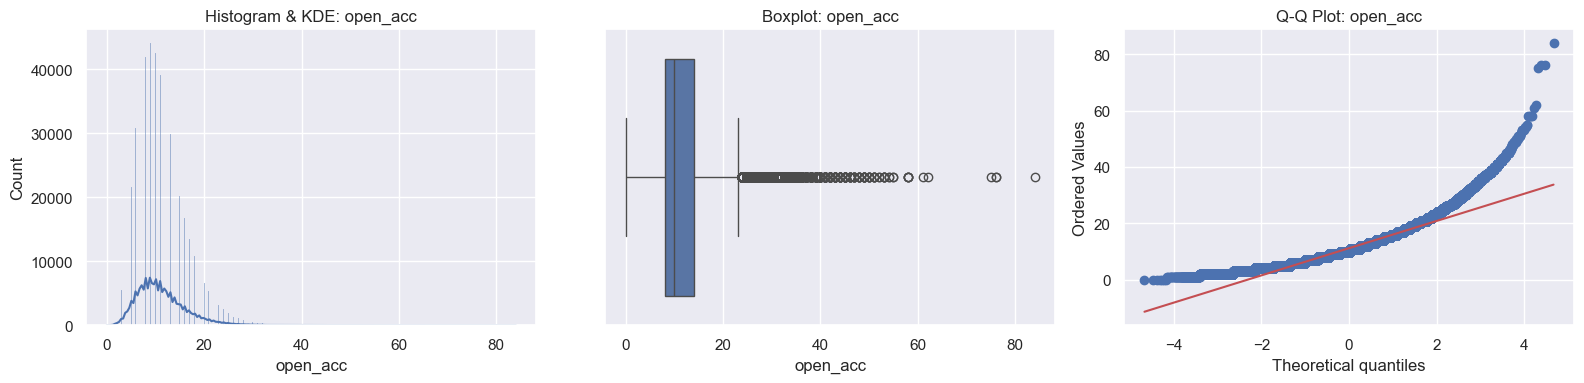


=== Statistics for pub_rec ===


Statistic,Value
Minimum,0.0
5-th Percentile,0.0
Q1,0.0
Median,0.0
Q3,0.0
95-th Percentile,1.0
Maximum,63.0
Range,63.0
IQR,0.0
Statistic,Value


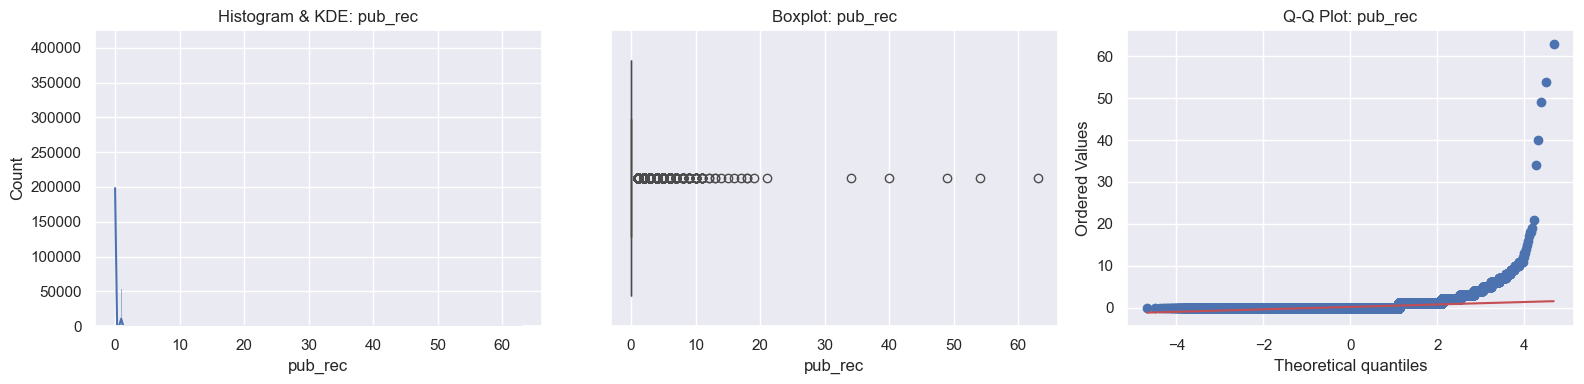


=== Statistics for revol_bal ===


Statistic,Value
Minimum,0.0
5-th Percentile,1955.0
Q1,6413.0
Median,11764.0
Q3,20333.0
95-th Percentile,40952.8
Maximum,2568995.0
Range,2568995.0
IQR,13920.0
Statistic,Value


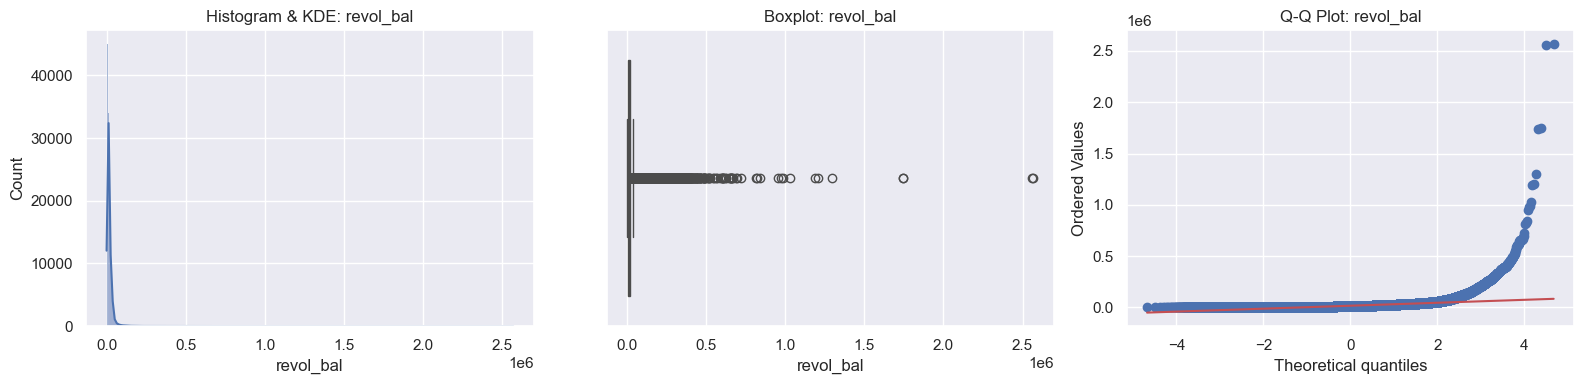


=== Statistics for total_acc ===


Statistic,Value
Minimum,1.0
5-th Percentile,9.0
Q1,17.0
Median,23.0
Q3,32.0
95-th Percentile,47.0
Maximum,156.0
Range,155.0
IQR,15.0
Statistic,Value


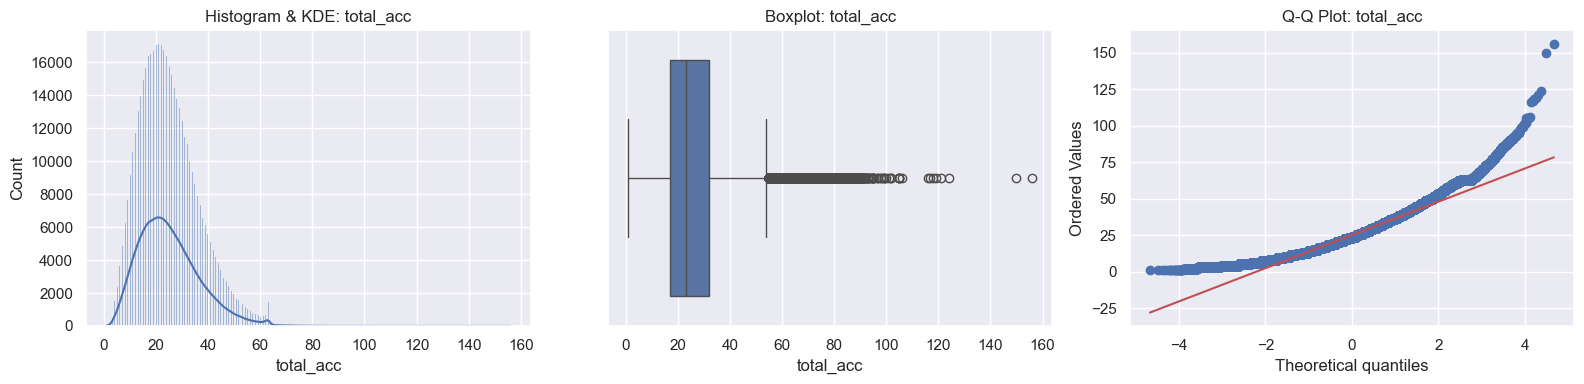


=== Statistics for acc_now_delinq ===


Statistic,Value
Minimum,0.0
5-th Percentile,0.0
Q1,0.0
Median,0.0
Q3,0.0
95-th Percentile,0.0
Maximum,5.0
Range,5.0
IQR,0.0
Statistic,Value


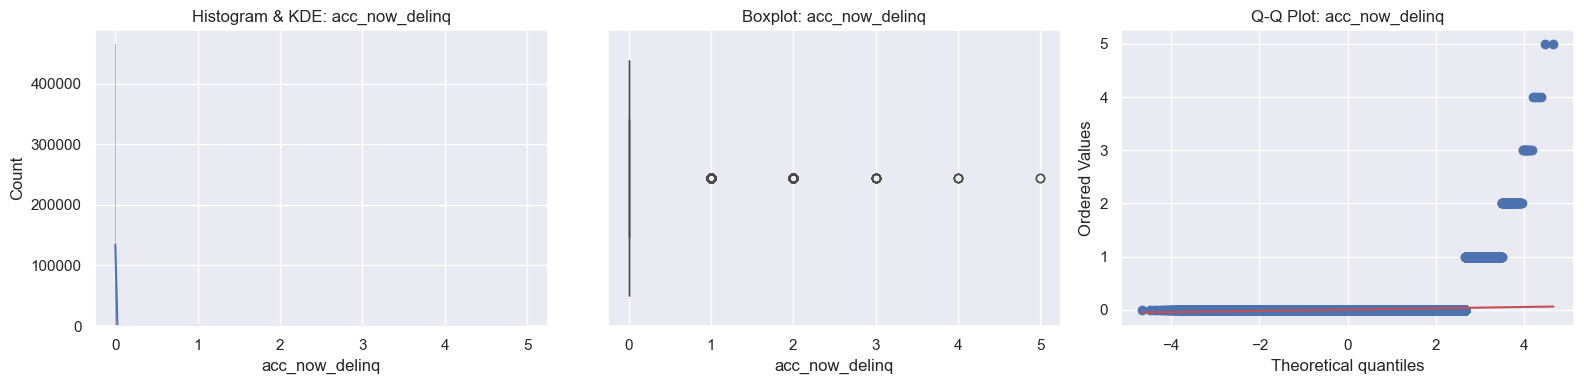


=== Statistics for tot_cur_bal ===


Statistic,Value
Minimum,0.0
5-th Percentile,0.0
Q1,15467.0
Median,52479.0
Q3,184930.0
95-th Percentile,399524.2
Maximum,8000078.0
Range,8000078.0
IQR,169463.0
Statistic,Value


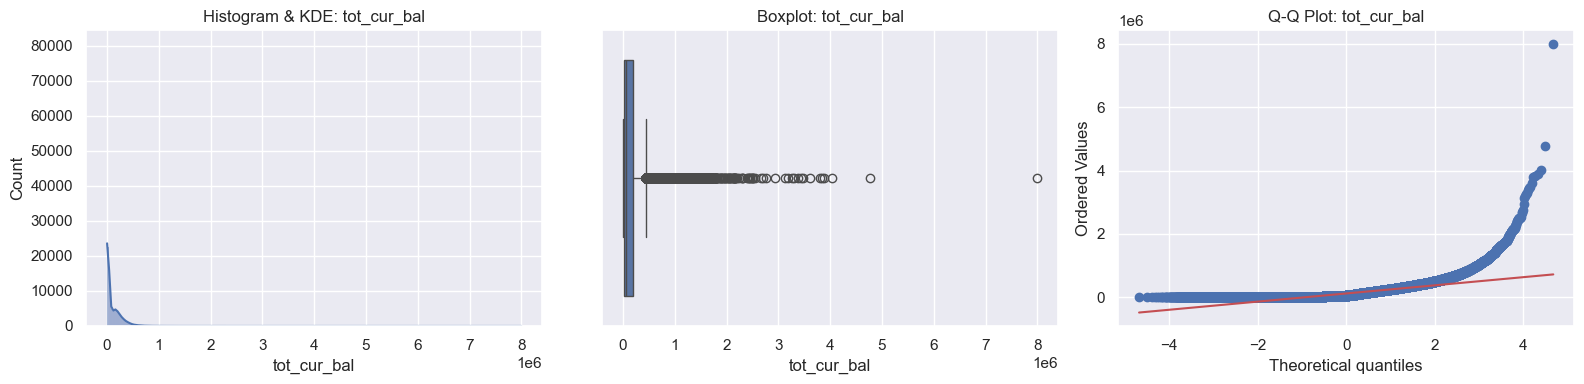

In [21]:
from scipy.stats import skew, kurtosis, probplot
from IPython.display import display_html


# Separate the latest numerical from categorical features
num_cols = df.select_dtypes(include=[np.number]).columns

# Statistics for numerical features
for col in num_cols:
    data = df[col].dropna()

    # Quantile Statistics
    quantile_stats = {
        'Minimum': data.min(),
        '5-th Percentile': np.percentile(data, 5),
        'Q1': data.quantile(0.25),
        'Median': data.median(),
        'Q3': data.quantile(0.75),
        '95-th Percentile': np.percentile(data, 95),
        'Maximum': data.max(),
        'Range': data.max() - data.min(),
        'IQR': data.quantile(0.75) - data.quantile(0.25)
    }

    # Descriptive Statistics
    descriptive_stats = {
        'Mean': data.mean(),
        'Standard Deviation': data.std(),
        'Variance': data.var(),
        'Sum': data.sum(),
        'Skewness': skew(data),
        'Kurtosis': kurtosis(data),
        'Coefficient of Variation': data.std() / data.mean()
    }

    # Convert to DataFrames
    quantile_df = pd.DataFrame(quantile_stats.items(), columns=["Statistic", "Value"])
    descriptive_df = pd.DataFrame(descriptive_stats.items(), columns=["Statistic", "Value"])

    # Convert DataFrames to HTML tables
    q_html = quantile_df.to_html(index=False)
    d_html = descriptive_df.to_html(index=False)

    # Display Side by Side
    print(f"\n=== Statistics for {col} ===")
    display_html(f"""
        <div style='display: flex; gap: 40px;'>
            <div><h3>Quantile Statistics</h3>{q_html}</div>
            <div><h3>Descriptive Statistics</h3>{d_html}</div>
        </div>
    """, raw=True)

    # Plots
    plt.figure(figsize=(16, 4))

    # Histogram + KDE
    plt.subplot(1, 3, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram & KDE: {col}')

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=data)
    plt.title(f'Boxplot: {col}')

    # Q-Q Plot
    plt.subplot(1, 3, 3)
    probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot: {col}')

    plt.tight_layout()
    plt.show()

In [22]:
from scipy.stats import skew

#Checking the skewness

def check_skewness_outlier_effect(df):
    skew_report = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        data = df[col].dropna()

        # Skewness before
        original_skew = skew(data)

        # Outlier removal using IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

        # Skewness after
        filtered_skew = skew(filtered_data)

        # Interpretation
        def interpret_skew(value):
            if abs(value) < 0.5:
                return "Symmetric"
            elif abs(value) < 1:
                return "Moderately Skewed"
            else:
                return "Highly Skewed"

        skew_report.append({
            'Feature': col,
            'Skewness Before': round(original_skew, 4),
            'Interpretation Before': interpret_skew(original_skew),
            'Skewness After': round(filtered_skew, 4),
            'Interpretation After': interpret_skew(filtered_skew),
            'Change': round(original_skew - filtered_skew, 4)
        })

    return pd.DataFrame(skew_report)


In [23]:
report = check_skewness_outlier_effect(df)
print(report)

           Feature  Skewness Before Interpretation Before  Skewness After  \
0        loan_amnt           0.7310     Moderately Skewed          0.7310   
1         int_rate           0.3349             Symmetric          0.2368   
2      installment           0.9493     Moderately Skewed          0.6225   
3       annual_inc          29.5689         Highly Skewed          0.7311   
4              dti           0.1883             Symmetric          0.1871   
5      delinq_2yrs           5.3459         Highly Skewed             NaN   
6         open_acc           1.1658         Highly Skewed          0.5443   
7          pub_rec          14.9417         Highly Skewed             NaN   
8        revol_bal          19.4762         Highly Skewed          0.8841   
9        total_acc           0.8131     Moderately Skewed          0.4676   
10  acc_now_delinq          20.7989         Highly Skewed             NaN   
11     tot_cur_bal           3.0721         Highly Skewed          1.1351   

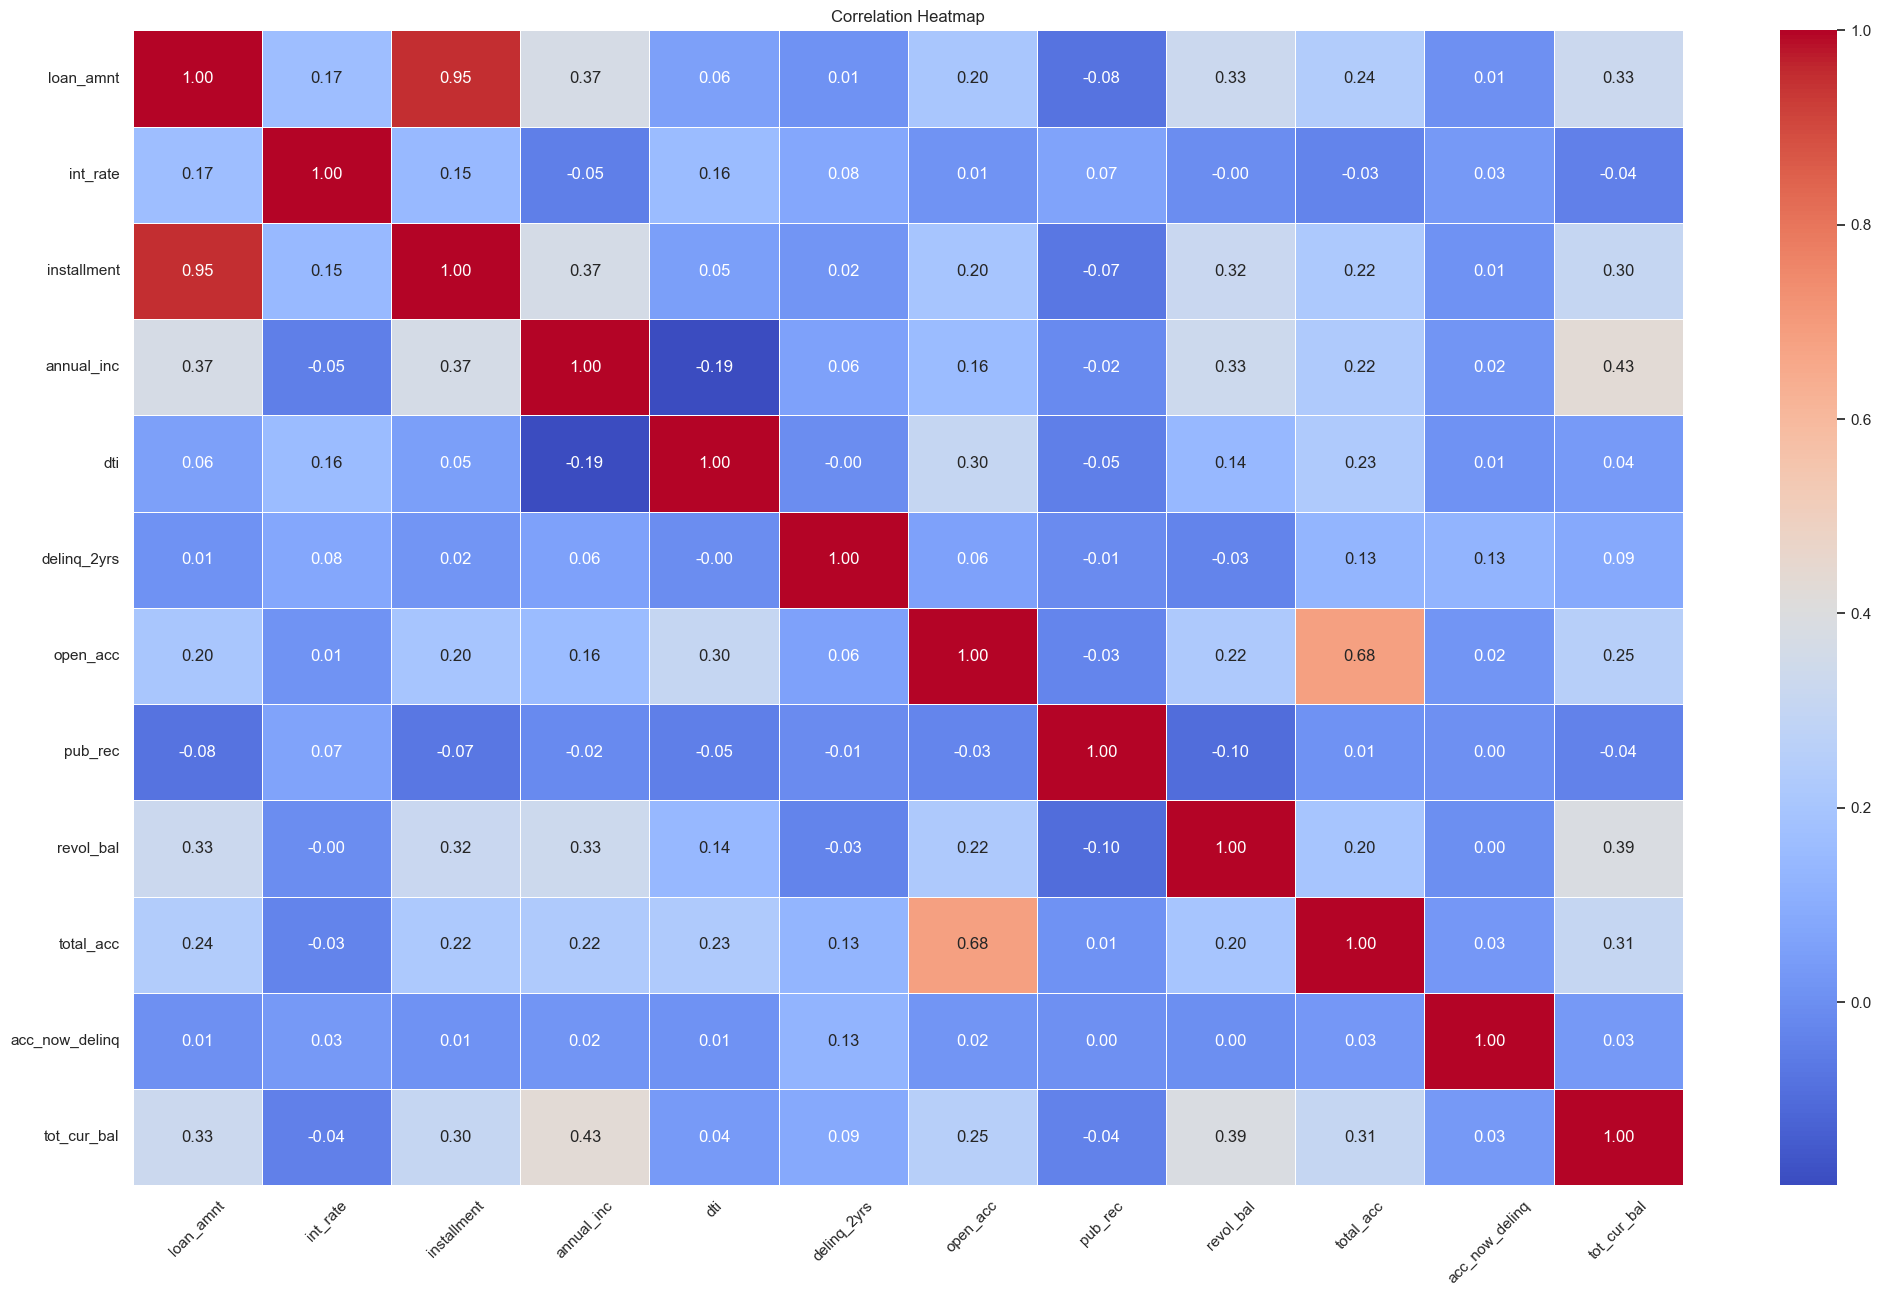

In [24]:
numerical_dataset = df.select_dtypes(include=['number'])
correlation_ = numerical_dataset.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### 2.3.2 Categorical Features Univariate Analysis

Stats for term 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 2 
 
 
 Mode (top category) 
 36 months 
 
 
 Mode count 
 337953 
 
 
 Mode (%) 
 72.48 
 
 
 Entropy (bits) 
 0.8489 
 
 
 Gini diversity 
 0.3989 
 
 
 Avg. length 
 10.0 
 
 
 Min length 
 10 
 
 
 Max length 
 10 
 
 
 
 
 
 Value Table (top 2) 
 
 
 
 term 
 Count 
 Percentage 
 
 
 
 
 36 months 
 337953 
 72.48 
 
 
 60 months 
 128332 
 27.52

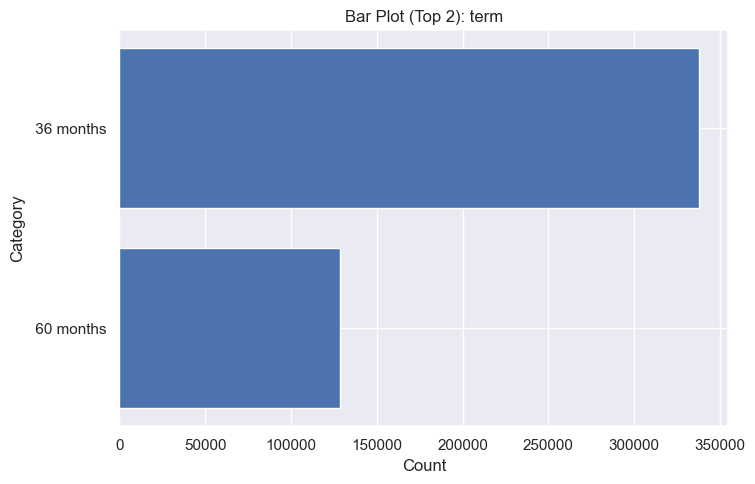

Stats for sub_grade 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 35 
 
 
 Mode (top category) 
 B3 
 
 
 Mode count 
 31686 
 
 
 Mode (%) 
 6.8 
 
 
 Entropy (bits) 
 4.6604 
 
 
 Gini diversity 
 0.9553 
 
 
 Avg. length 
 2.0 
 
 
 Min length 
 2 
 
 
 Max length 
 2 
 
 
 
 
 
 Value Table (top 35) 
 
 
 
 sub_grade 
 Count 
 Percentage 
 
 
 
 
 B3 
 31686 
 6.80 
 
 
 B4 
 30505 
 6.54 
 
 
 C1 
 26953 
 5.78 
 
 
 C2 
 26740 
 5.73 
 
 
 B2 
 26610 
 5.71 
 
 
 C3 
 25317 
 5.43 
 
 
 B5 
 25252 
 5.42 
 
 
 C4 
 24105 
 5.17 
 
 
 B1 
 22876 
 4.91 
 
 
 C5 
 22178 
 4.76 
 
 
 A5 
 21757 
 4.67 
 
 
 D1 
 19261 
 4.13 
 
 
 A4 
 19045 
 4.08 
 
 
 D2 
 17046 
 3.66 
 
 
 D3 
 14916 
 3.20 
 
 
 D4 
 14099 
 3.02 
 
 
 A3 
 12568 
 2.70 
 
 
 D5 
 11566 
 2.48 
 
 
 A2 
 10956 
 2.35 
 
 
 A1 
 10541 
 2.26 
 
 
 E1 
 9033 
 1.94 
 
 
 E2 
 8669 
 1.86 
 
 
 E3 
 6976 
 1.50 
 
 
 E4 
 5992 
 1.29 
 
 
 E5 
 5087 
 1.09 
 
 
 F1 
 3940 
 0.84 
 
 
 F2 
 3001 
 0.64 
 
 
 F3 
 2708 
 0.58 
 
 
 F4 
 2067 
 0.44 
 
 
 F5 
 1513 
 0.32 
 
 
 G1 
 1109 
 0.24 
 
 
 G2 
 823 
 0.18 
 
 
 G3 
 583 
 0.13 
 
 
 G4 
 422 
 0.09 
 
 
 G5 
 385 
 0.08

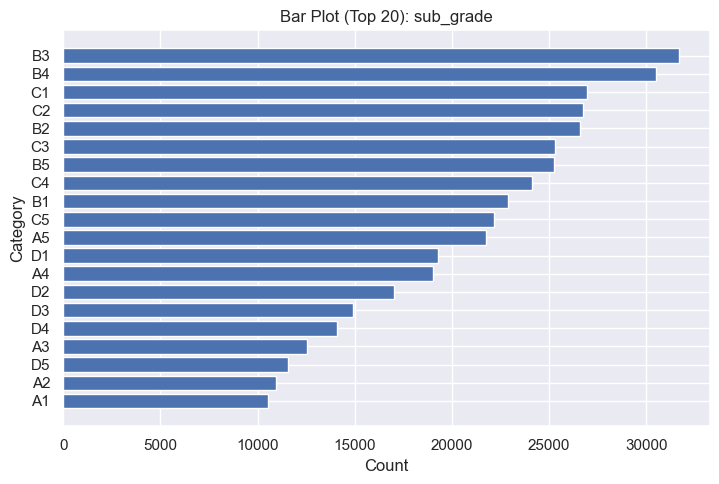

Stats for emp_length 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 11 
 
 
 Mode (top category) 
 10+ years 
 
 
 Mode count 
 171057 
 
 
 Mode (%) 
 36.69 
 
 
 Entropy (bits) 
 3.0277 
 
 
 Gini diversity 
 0.8233 
 
 
 Avg. length 
 7.75 
 
 
 Min length 
 6 
 
 
 Max length 
 9 
 
 
 
 
 
 Value Table (top 11) 
 
 
 
 emp_length 
 Count 
 Percentage 
 
 
 
 
 10+ years 
 171057 
 36.69 
 
 
 2 years 
 41373 
 8.87 
 
 
 3 years 
 36596 
 7.85 
 
 
 < 1 year 
 36265 
 7.78 
 
 
 5 years 
 30774 
 6.60 
 
 
 1 year 
 29622 
 6.35 
 
 
 4 years 
 28023 
 6.01 
 
 
 7 years 
 26180 
 5.61 
 
 
 6 years 
 26112 
 5.60 
 
 
 8 years 
 22395 
 4.80 
 
 
 9 years 
 17888 
 3.84

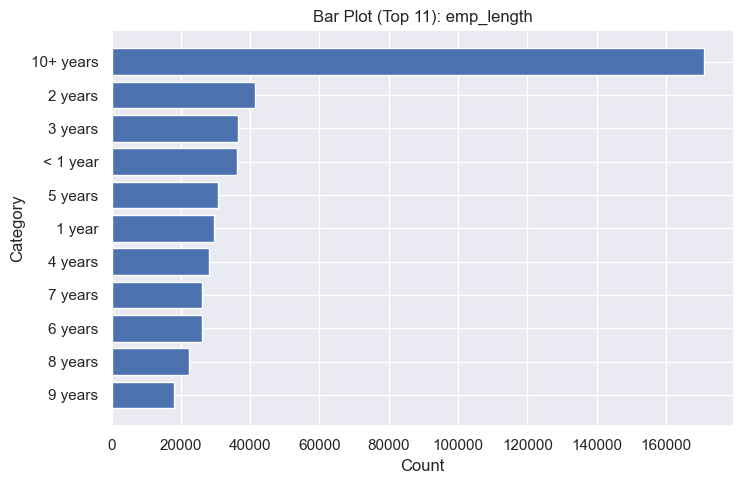

Stats for home_ownership 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 6 
 
 
 Mode (top category) 
 MORTGAGE 
 
 
 Mode count 
 235875 
 
 
 Mode (%) 
 50.59 
 
 
 Entropy (bits) 
 1.343 
 
 
 Gini diversity 
 0.5727 
 
 
 Avg. length 
 5.93 
 
 
 Min length 
 3 
 
 
 Max length 
 8 
 
 
 
 
 
 Value Table (top 6) 
 
 
 
 home_ownership 
 Count 
 Percentage 
 
 
 
 
 MORTGAGE 
 235875 
 50.59 
 
 
 RENT 
 188473 
 40.42 
 
 
 OWN 
 41704 
 8.94 
 
 
 OTHER 
 182 
 0.04 
 
 
 NONE 
 50 
 0.01 
 
 
 ANY 
 1 
 0.00

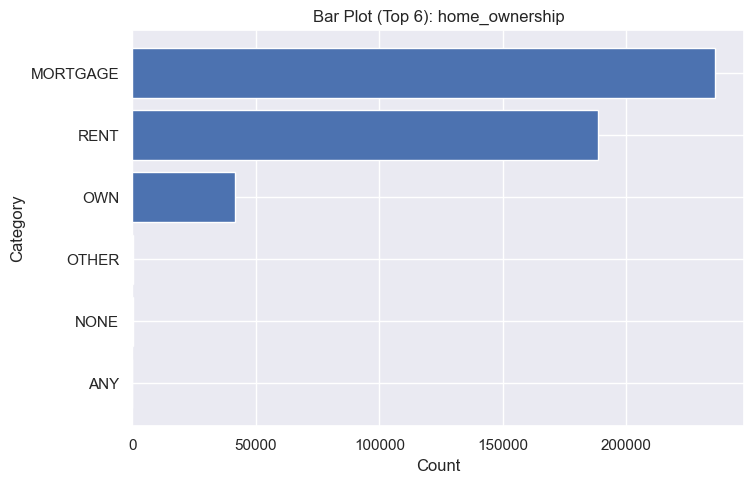

Stats for verification_status 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 3 
 
 
 Mode (top category) 
 Verified 
 
 
 Mode count 
 168055 
 
 
 Mode (%) 
 36.04 
 
 
 Entropy (bits) 
 1.5826 
 
 
 Gini diversity 
 0.6656 
 
 
 Avg. length 
 11.52 
 
 
 Min length 
 8 
 
 
 Max length 
 15 
 
 
 
 
 
 Value Table (top 3) 
 
 
 
 verification_status 
 Count 
 Percentage 
 
 
 
 
 Verified 
 168055 
 36.04 
 
 
 Source Verified 
 149993 
 32.17 
 
 
 Not Verified 
 148237 
 31.79

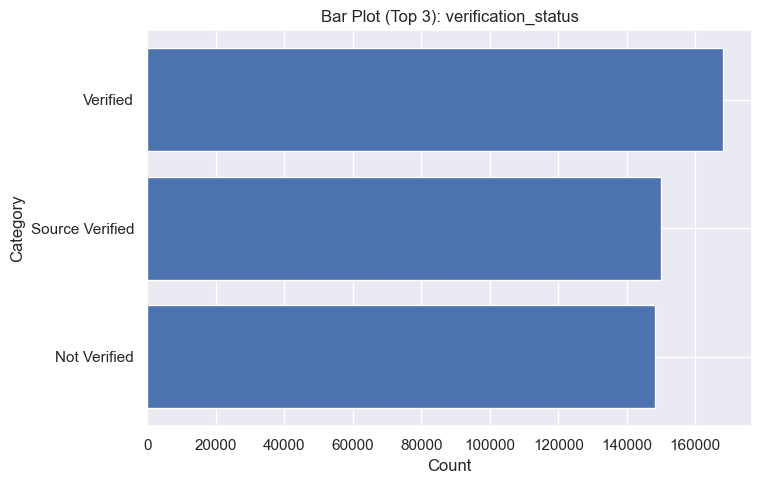

Stats for loan_status 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 9 
 
 
 Mode (top category) 
 Current 
 
 
 Mode count 
 224226 
 
 
 Mode (%) 
 48.09 
 
 
 Entropy (bits) 
 1.578 
 
 
 Gini diversity 
 0.6032 
 
 
 Avg. length 
 9.05 
 
 
 Min length 
 7 
 
 
 Max length 
 51 
 
 
 
 
 
 Value Table (top 9) 
 
 
 
 loan_status 
 Count 
 Percentage 
 
 
 
 
 Current 
 224226 
 48.09 
 
 
 Fully Paid 
 184739 
 39.62 
 
 
 Charged Off 
 42475 
 9.11 
 
 
 Late (31-120 days) 
 6900 
 1.48 
 
 
 In Grace Period 
 3146 
 0.67 
 
 
 Does not meet the credit policy. Status:Fully Paid 
 1988 
 0.43 
 
 
 Late (16-30 days) 
 1218 
 0.26 
 
 
 Default 
 832 
 0.18 
 
 
 Does not meet the credit policy. Status:Charged Off 
 761 
 0.16

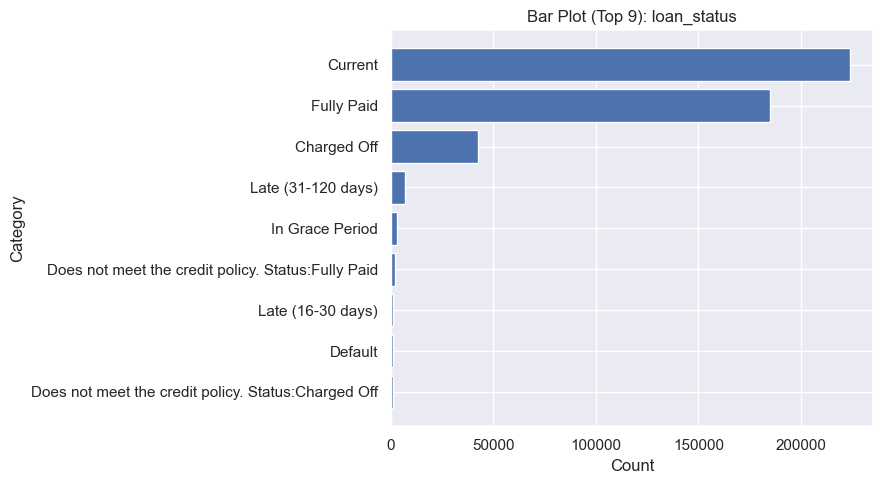

Stats for purpose 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 14 
 
 
 Mode (top category) 
 debt_consolidation 
 
 
 Mode count 
 274195 
 
 
 Mode (%) 
 58.8 
 
 
 Entropy (bits) 
 1.9156 
 
 
 Gini diversity 
 0.5975 
 
 
 Avg. length 
 14.98 
 
 
 Min length 
 3 
 
 
 Max length 
 18 
 
 
 
 
 
 Value Table (top 14) 
 
 
 
 purpose 
 Count 
 Percentage 
 
 
 
 
 debt_consolidation 
 274195 
 58.80 
 
 
 credit_card 
 104157 
 22.34 
 
 
 home_improvement 
 26537 
 5.69 
 
 
 other 
 23690 
 5.08 
 
 
 major_purchase 
 9828 
 2.11 
 
 
 small_business 
 7013 
 1.50 
 
 
 car 
 5397 
 1.16 
 
 
 medical 
 4602 
 0.99 
 
 
 moving 
 2994 
 0.64 
 
 
 vacation 
 2487 
 0.53 
 
 
 wedding 
 2343 
 0.50 
 
 
 house 
 2269 
 0.49 
 
 
 educational 
 422 
 0.09 
 
 
 renewable_energy 
 351 
 0.08

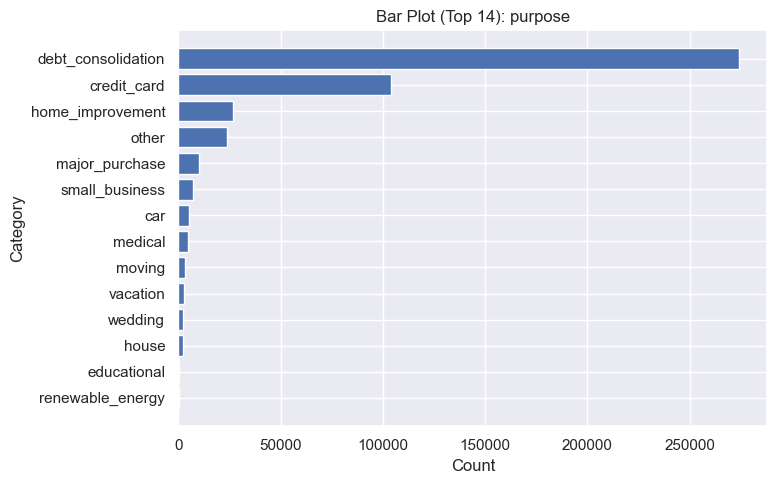

Stats for earliest_cr_line 
 
 
 
 Metric 
 Value 
 
 
 
 
 Unique (cardinality) 
 664 
 
 
 Mode (top category) 
 Oct-00 
 
 
 Mode count 
 3703 
 
 
 Mode (%) 
 0.79 
 
 
 Entropy (bits) 
 8.3331 
 
 
 Gini diversity 
 0.9962 
 
 
 Avg. length 
 6.0 
 
 
 Min length 
 6 
 
 
 Max length 
 6 
 
 
 
 
 
 Value Table (top 50) 
 
 
 
 earliest_cr_line 
 Count 
 Percentage 
 
 
 
 
 Oct-00 
 3703 
 0.79 
 
 
 Aug-00 
 3597 
 0.77 
 
 
 Aug-01 
 3455 
 0.74 
 
 
 Oct-99 
 3406 
 0.73 
 
 
 Oct-01 
 3329 
 0.71 
 
 
 Nov-99 
 3323 
 0.71 
 
 
 Nov-00 
 3267 
 0.70 
 
 
 Sep-00 
 3256 
 0.70 
 
 
 Sep-99 
 3130 
 0.67 
 
 
 Aug-99 
 3126 
 0.67 
 
 
 Sep-01 
 3061 
 0.66 
 
 
 Oct-02 
 3016 
 0.65 
 
 
 Dec-99 
 2968 
 0.64 
 
 
 Dec-00 
 2951 
 0.63 
 
 
 Nov-98 
 2899 
 0.62 
 
 
 Dec-98 
 2883 
 0.62 
 
 
 Oct-98 
 2862 
 0.61 
 
 
 Aug-02 
 2851 
 0.61 
 
 
 Sep-02 
 2846 
 0.61 
 
 
 Jul-00 
 2835 
 0.61 
 
 
 May-01 
 2819 
 0.60 
 
 
 Jul-01 
 2798 
 0.60 
 
 
 Nov-01 
 2797 
 0.60 
 
 
 Jan-01 
 2797 
 0.60 
 
 
 Sep-98 
 2782 
 0.60 
 
 
 May-00 
 2778 
 0.60 
 
 
 Mar-01 
 2757 
 0.59 
 
 
 Mar-00 
 2732 
 0.59 
 
 
 Dec-01 
 2726 
 0.58 
 
 
 Jun-01 
 2718 
 0.58 
 
 
 Jan-00 
 2685 
 0.58 
 
 
 Jun-00 
 2664 
 0.57 
 
 
 Feb-00 
 2644 
 0.57 
 
 
 Oct-03 
 2610 
 0.56 
 
 
 Sep-03 
 2580 
 0.55 
 
 
 Aug-98 
 2580 
 0.55 
 
 
 Apr-01 
 2544 
 0.55 
 
 
 Jul-99 
 2533 
 0.54 
 
 
 Mar-99 
 2501 
 0.54 
 
 
 Dec-97 
 2463 
 0.53 
 
 
 Apr-00 
 2456 
 0.53 
 
 
 Oct-97 
 2442 
 0.52 
 
 
 Jul-02 
 2435 
 0.52 
 
 
 Feb-01 
 2432 
 0.52 
 
 
 Jan-02 
 2419 
 0.52 
 
 
 Jun-99 
 2413 
 0.52 
 
 
 Nov-97 
 2404 
 0.52 
 
 
 May-99 
 2386 
 0.51 
 
 
 Aug-03 
 2347 
 0.50 
 
 
 Nov-96 
 2325 
 0.50

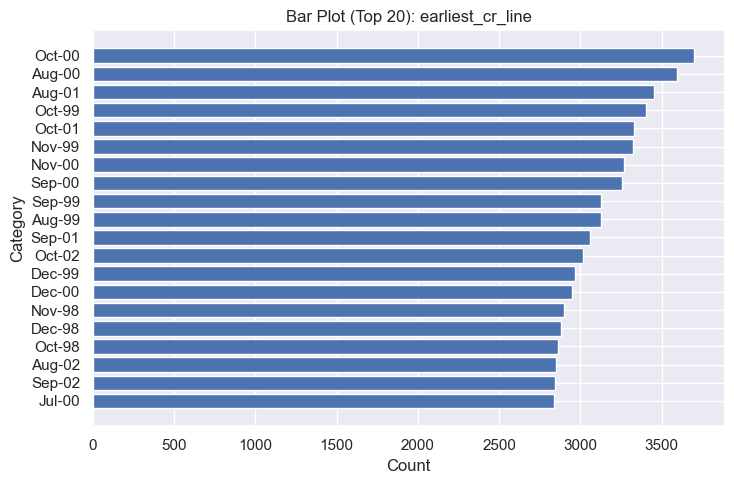

In [25]:
# Define the latest categorical features
cat_cols = df.select_dtypes(exclude=[np.number]).columns

# statistic function
def _cat_stats_core(series: pd.Series) -> pd.DataFrame:
    s_nn = series.dropna()
    if s_nn.empty:
        return pd.DataFrame({
            "Metric": [
                "Unique (cardinality)", "Mode (top category)", "Mode count", 
                "Mode (%)", "Entropy (bits)", "Gini diversity", 
                "Avg. length", "Min length", "Max length"
            ],
            "Value": [np.nan]*9
        })
    
    vc = s_nn.value_counts()
    mode_val = vc.index[0]
    mode_count = int(vc.iloc[0])
    mode_pct = mode_count / s_nn.shape[0] * 100
    p = (vc / s_nn.shape[0]).values
    entropy = -np.sum(p * np.log2(p))
    gini = 1 - np.sum(p**2)
    lens = s_nn.astype(str).str.len()
    avg_len, min_len, max_len = lens.mean(), lens.min(), lens.max()

    return pd.DataFrame({
        "Metric": [
            "Unique (cardinality)", "Mode (top category)", "Mode count",
            "Mode (%)", "Entropy (bits)", "Gini diversity",
            "Avg. length", "Min length", "Max length"
        ],
        "Value": [
            s_nn.nunique(), mode_val, mode_count, round(mode_pct, 2),
            round(entropy, 4), round(gini, 4),
            round(avg_len, 2), min_len, max_len
        ]
    })

# Main function
def analyze_categorical_features(df, top_n_bar=20, top_n_table=50, top_n_pie=10):
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    if len(cat_cols) == 0:
        print("No categorical features found.")
        return

    for col in cat_cols:
        s = df[col]
        s_nn = s.dropna()

        # Stats table
        stats_df = _cat_stats_core(s)

        # Value table
        vc = s_nn.value_counts()
        vt = (
            vc.head(top_n_table)
              .rename("Count")
              .to_frame()
              .assign(Percentage=lambda d: (d["Count"] / len(s_nn) * 100).round(2))
              .reset_index()
              .rename(columns={"index": col})
        )

        # Display tables side-by-side
        display_html(
            f"""
            <div style="display:flex; gap:40px; align-items:flex-start;">
                <div style="flex:0 0 360px;">
                    <h3>Stats for {col}</h3>
                    {stats_df.to_html(index=False)}
                </div>
                <div style="flex:1;">
                    <h3>Value Table (top {min(top_n_table, len(vc))})</h3>
                    {vt.to_html(index=False)}
                </div>
            </div>
            """,
            raw=True
        )

        # Bar plot
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        vc_bar = vc.head(top_n_bar)[::-1]
        plt.barh(vc_bar.index.astype(str), vc_bar.values)
        plt.title(f'Bar Plot (Top {min(top_n_bar, len(vc))}): {col}')
        plt.xlabel('Count')
        plt.ylabel('Category')

        plt.tight_layout()
        plt.show()


analyze_categorical_features(df)



In [26]:
from scipy.stats import entropy
import pandas as pd

def check_categorical_imbalance(df, dominance_threshold=3, entropy_threshold=1.0):
    cat_report = []
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        counts = df[col].value_counts()
        dominance_ratio = counts.max() / counts.min() if counts.min() > 0 else None
        ent = entropy(counts)

        # Determine imbalance flag
        if (dominance_ratio and dominance_ratio >= dominance_threshold) or (ent <= entropy_threshold):
            flag = "Imbalanced"
        else:
            flag = "Balanced"

        cat_report.append({
            'Feature': col,
            'Unique Categories': len(counts),
            'Entropy': round(ent, 3),
            'Dominance Ratio': round(dominance_ratio, 2) if dominance_ratio else None,
            'Most Common Category': counts.idxmax(),
            'Most Common Freq (%)': round((counts.max()/counts.sum())*100, 2),
            'Imbalance Flag': flag
        })
    return pd.DataFrame(cat_report)

report = check_categorical_imbalance(df)
print(report)

               Feature  Unique Categories  Entropy  Dominance Ratio  \
0                 term                  2    0.588             2.63   
1            sub_grade                 35    3.230            82.30   
2           emp_length                 11    2.099             9.56   
3       home_ownership                  6    0.931        235875.00   
4  verification_status                  3    1.097             1.13   
5          loan_status                  9    1.094           294.65   
6              purpose                 14    1.328           781.18   
7     earliest_cr_line                664    5.776          3703.00   

  Most Common Category  Most Common Freq (%) Imbalance Flag  
0            36 months                 72.48     Imbalanced  
1                   B3                  6.80     Imbalanced  
2            10+ years                 36.69     Imbalanced  
3             MORTGAGE                 50.59     Imbalanced  
4             Verified                 36.04      

## 2.4 Bivariate Analysis

In [27]:

from IPython.display import display_html

def bivariate_analysis(df, target="loan_status"):
    df = df.copy()
    df = df[df[target].isin(["Fully Paid", "Charged Off"])]
    df[target] = df[target].map({
        "Fully Paid": "Good Loan",
        "Charged Off": "Bad Loan"
    })
    
    # Separate features
    num_cols = df.select_dtypes(include=["float", "int"]).columns.drop(target, errors="ignore")
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.drop(target, errors="ignore")

    # --- Numerical Features ---
    for col in num_cols:
        print(f"\n=== Numerical Feature: {col} vs {target} ===")

        # Stats per class
        stats_good = df[df[target] == "Good Loan"][col].describe().round(2)
        stats_bad = df[df[target] == "Bad Loan"][col].describe().round(2)
        stats_df = pd.DataFrame({"Good Loan": stats_good, "Bad Loan": stats_bad})
        
        # Display side-by-side table
        display_html(f"""
        <h4>Descriptive Stats for {col}</h4>
        {stats_df.to_html()}
        """, raw=True)

        # Boxplot
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=target, y=col, data=df, palette="Set2")
        plt.title(f"Boxplot of {col} by Loan Status")

        # KDE Plot
        plt.subplot(1, 2, 2)
        for label, color in zip(["Good Loan", "Bad Loan"], ["green", "red"]):
            sns.kdeplot(df[df[target]==label][col], label=label, fill=True, alpha=0.4, color=color)
        plt.title(f"KDE of {col} by Loan Status")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # --- Categorical Features ---
    for col in cat_cols:
        print(f"\n=== Categorical Feature: {col} vs {target} ===")

        # Crosstab for counts & percentage
        ct = pd.crosstab(df[col], df[target])
        pct = ct.div(ct.sum(axis=1), axis=0).mul(100).round(2)
        combined = ct.astype(str) + " (" + pct.astype(str) + "%)"
        
        display_html(f"""
        <h4>Counts & Percentages for {col}</h4>
        {combined.to_html()}
        """, raw=True)

        # Bar Plot
        plt.figure(figsize=(8, 5))
        ct.plot(kind="bar", stacked=False, figsize=(10, 5), color=["green", "red"])
        plt.title(f"{col} Distribution by Loan Status")
        plt.ylabel("Count")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



=== Numerical Feature: loan_amnt vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,13214.39,14518.76
std,7949.03,8373.18
min,500.00,900.00
25%,7125.00,8000.00
50%,11800.00,12600.00
75%,18000.00,20000.00
max,35000.00,35000.00


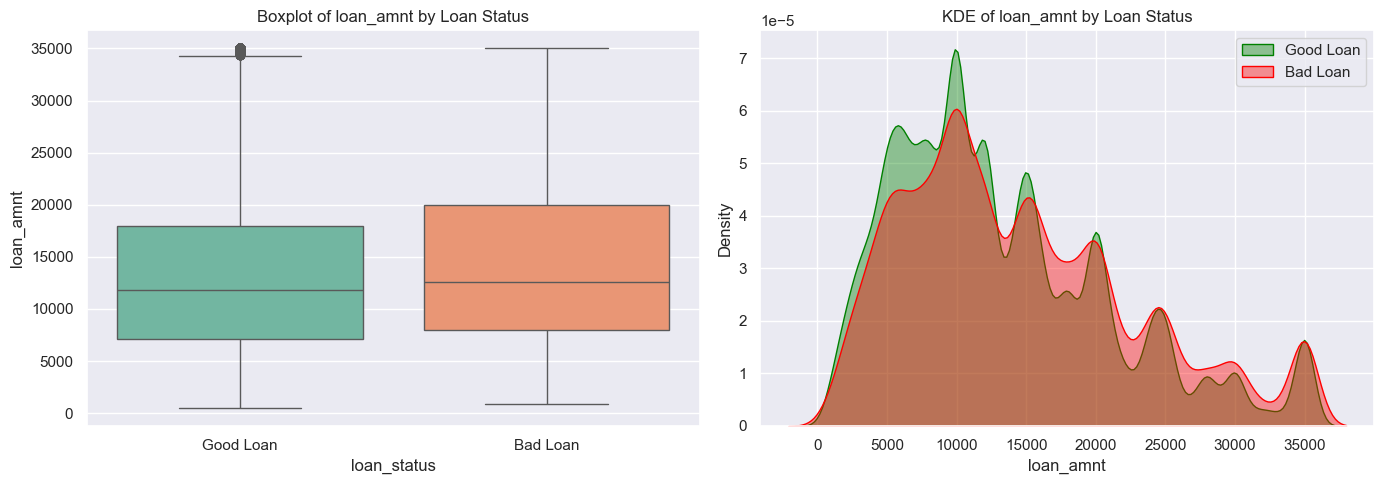


=== Numerical Feature: int_rate vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,13.26,16.00
std,4.24,4.29
min,5.42,5.42
25%,10.16,13.06
50%,13.11,15.80
75%,15.80,18.92
max,26.06,26.06


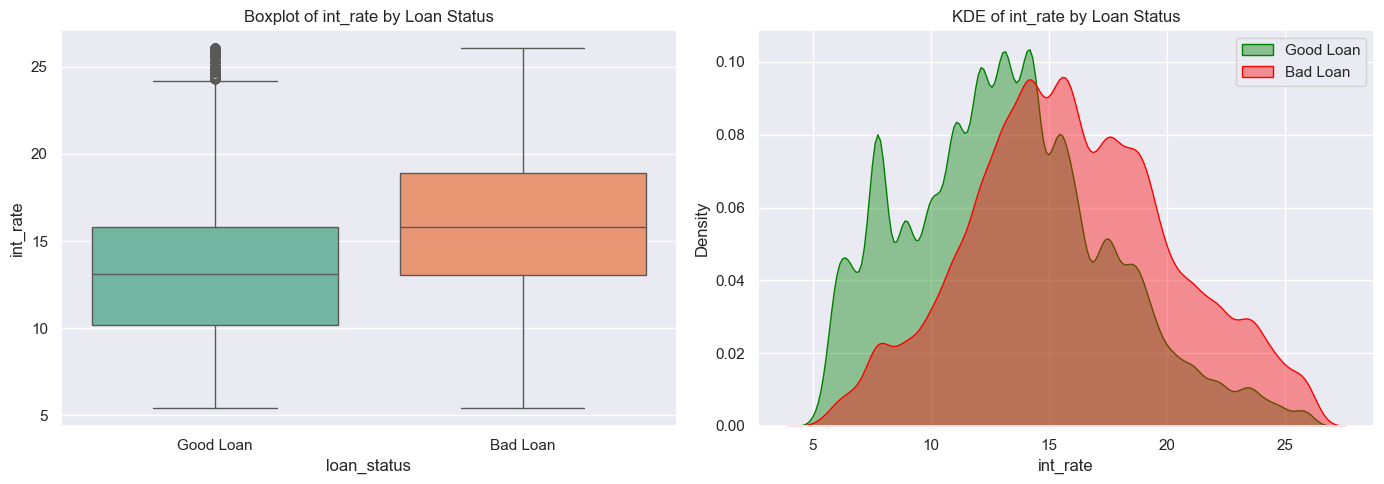


=== Numerical Feature: installment vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,411.09,439.99
std,242.56,246.23
min,15.69,21.62
25%,233.18,264.61
50%,358.77,391.26
75%,537.34,572.47
max,1408.13,1408.13


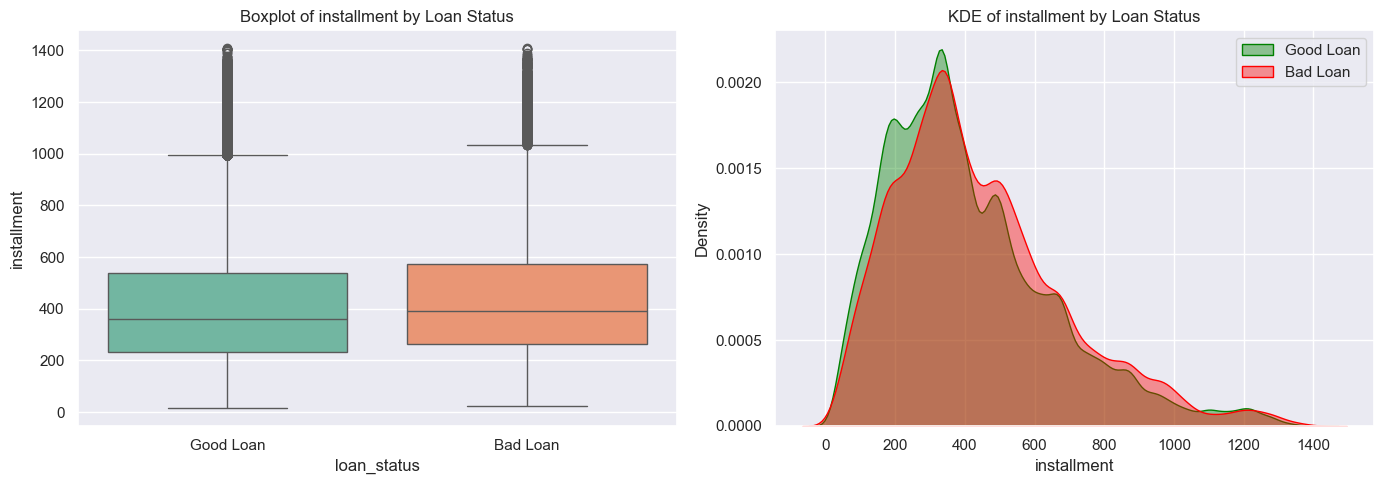


=== Numerical Feature: annual_inc vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,73709.61,64750.37
std,58122.43,39942.39
min,3000.00,4080.00
25%,45000.00,40000.00
50%,64000.00,56000.00
75%,90000.00,78000.00
max,7141778.00,932000.00


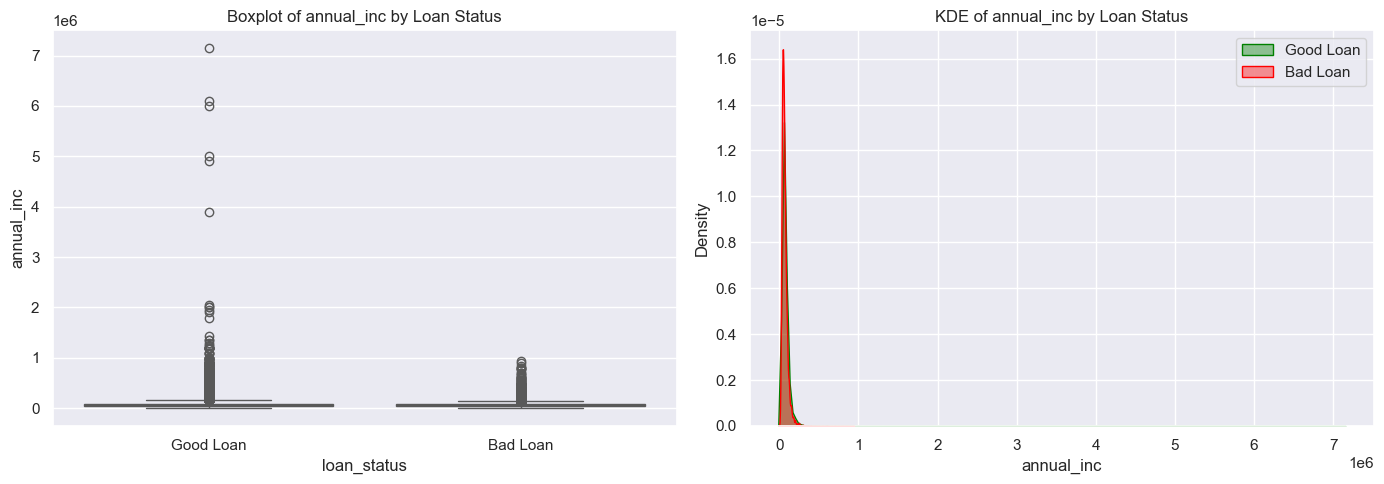


=== Numerical Feature: dti vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,15.94,18.22
std,7.57,7.82
min,0.00,0.00
25%,10.31,12.48
50%,15.58,18.22
75%,21.25,23.86
max,39.99,39.98


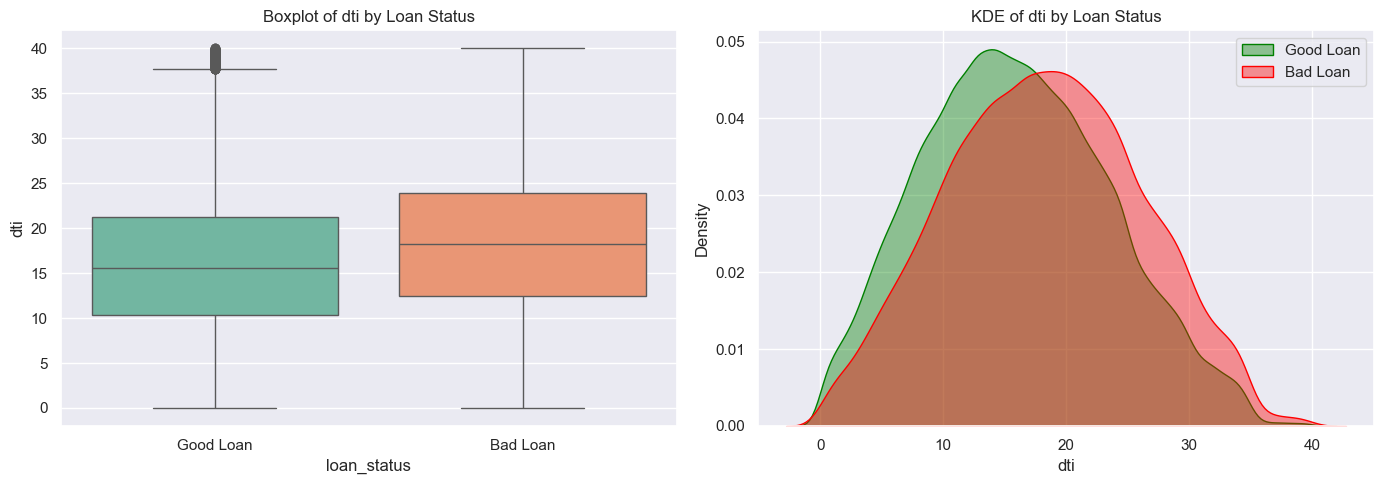


=== Numerical Feature: delinq_2yrs vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,0.24,0.27
std,0.71,0.78
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,29.00,18.00


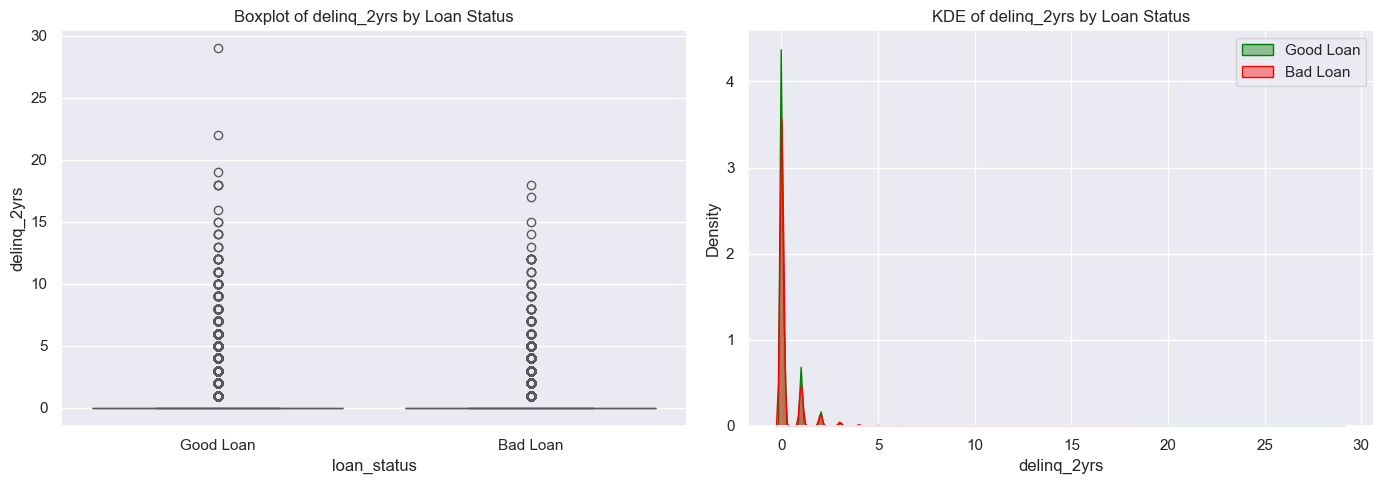


=== Numerical Feature: open_acc vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,10.79,11.00
std,4.78,4.89
min,0.00,0.00
25%,7.00,8.00
50%,10.00,10.00
75%,13.00,14.00
max,58.00,76.00


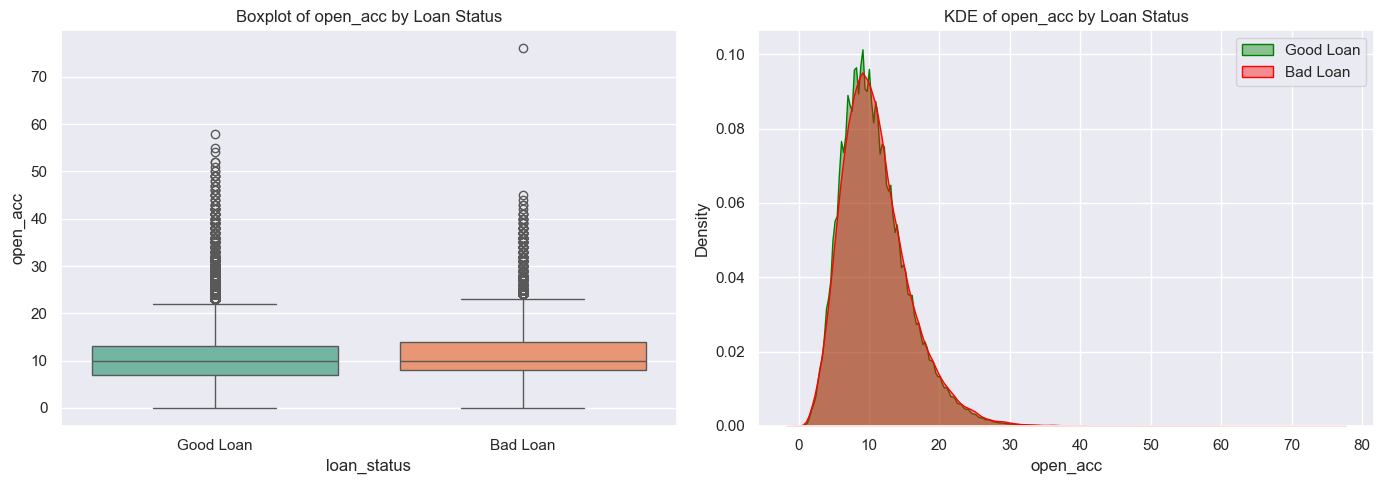


=== Numerical Feature: pub_rec vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,0.13,0.14
std,0.41,0.43
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,11.00,9.00


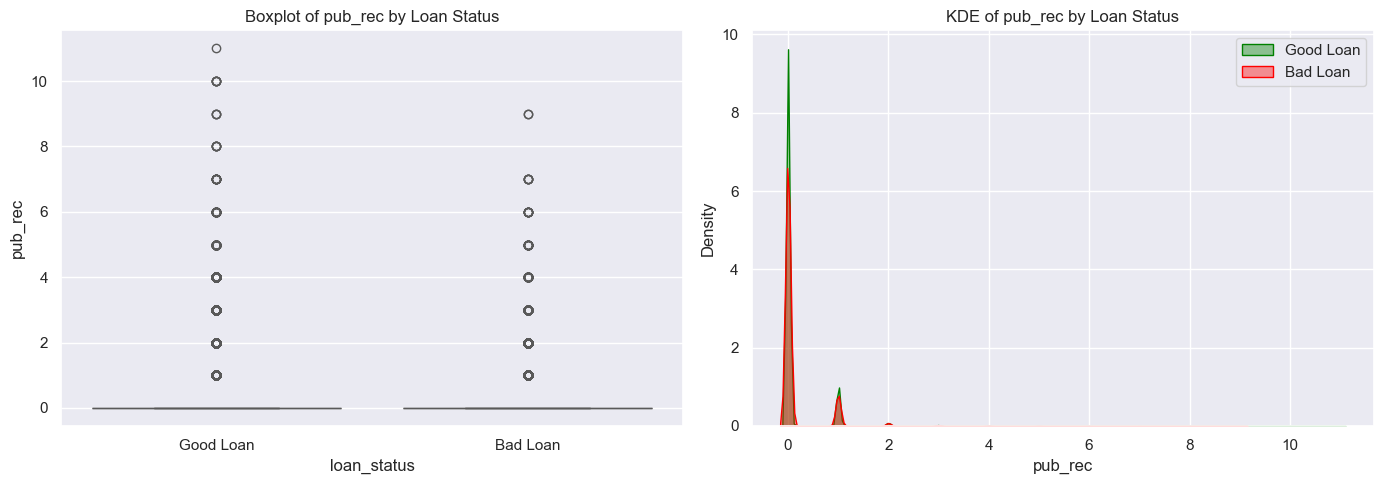


=== Numerical Feature: revol_bal vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,15112.55,14902.01
std,18377.38,16981.14
min,0.00,0.00
25%,5848.50,6288.00
50%,10913.00,11374.00
75%,19026.00,19136.00
max,1743266.00,1746716.00


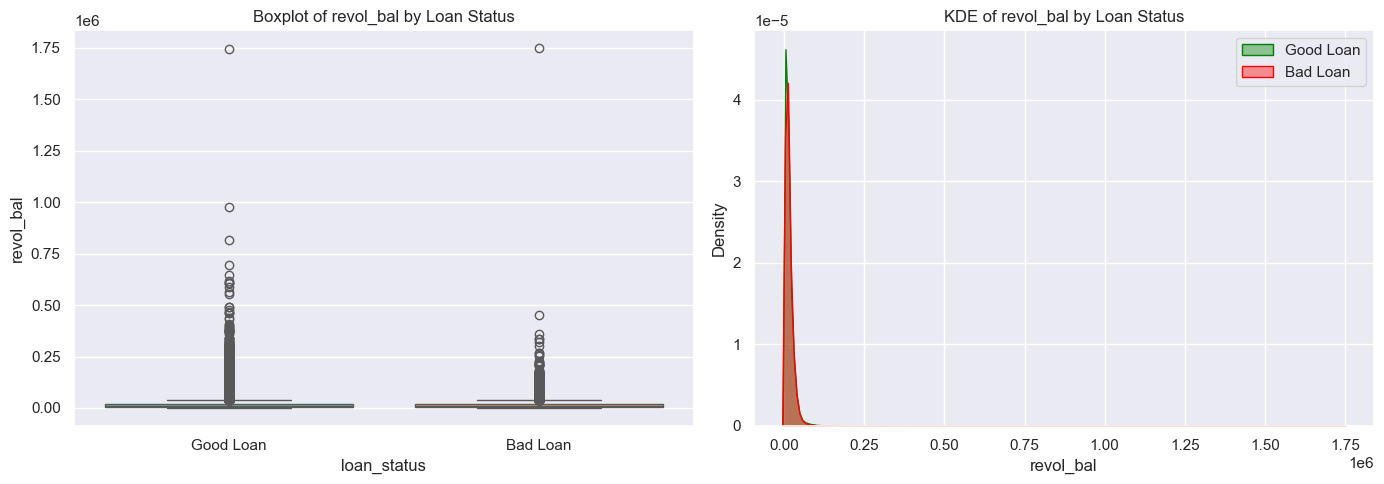


=== Numerical Feature: total_acc vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,24.97,24.14
std,11.65,11.46
min,2.00,2.00
25%,16.00,16.00
50%,23.00,23.00
75%,32.00,31.00
max,150.00,94.00


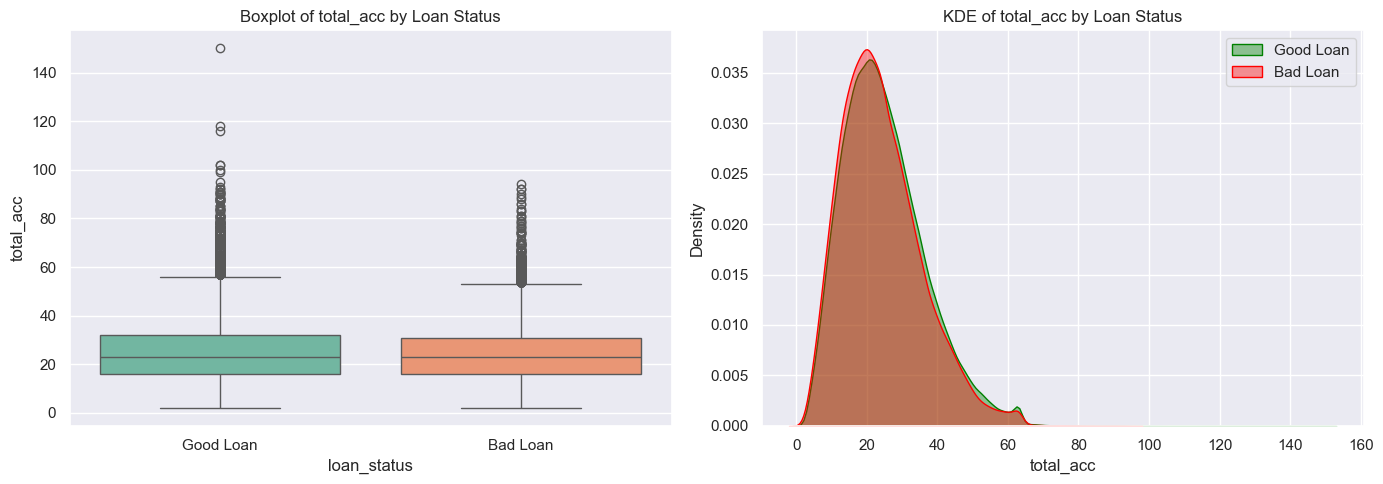


=== Numerical Feature: acc_now_delinq vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,0.00,0.00
std,0.05,0.07
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,5.00,5.00


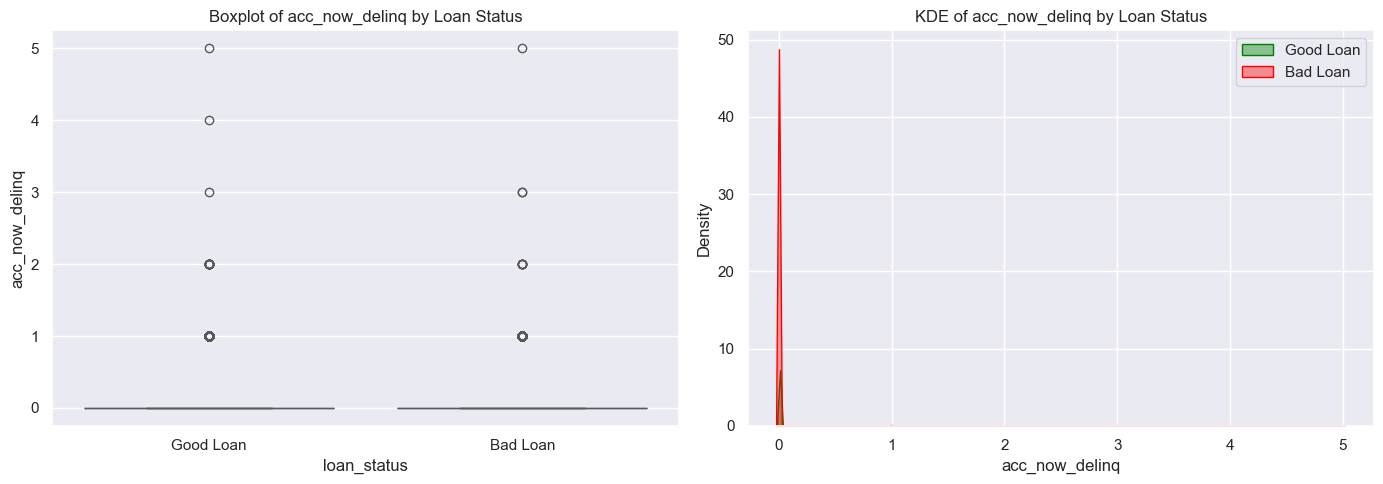


=== Numerical Feature: tot_cur_bal vs loan_status ===


,Good Loan,Bad Loan
count,184739.00,42475.00
mean,101445.66,87508.63
std,146230.02,121497.75
min,0.00,0.00
25%,0.00,4918.00
50%,34048.00,34628.00
75%,163840.50,135171.00
max,8000078.00,3437283.00


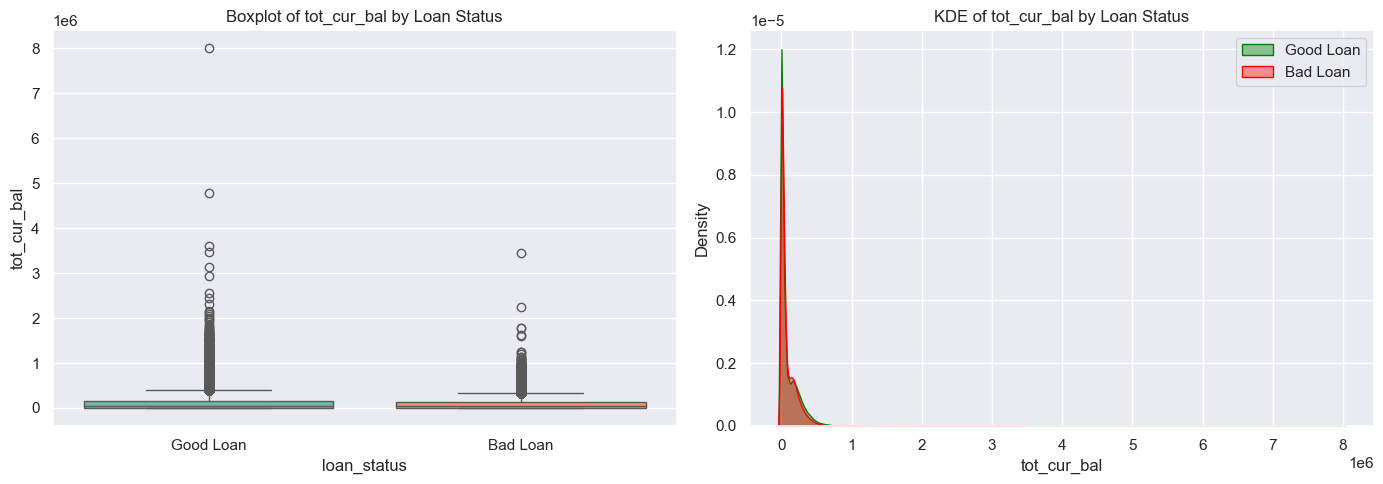


=== Categorical Feature: term vs loan_status ===


loan_status,Bad Loan,Good Loan
term,,
36 months,27455 (15.38%),151101 (84.62%)
60 months,15020 (30.87%),33638 (69.13%)


<Figure size 800x500 with 0 Axes>

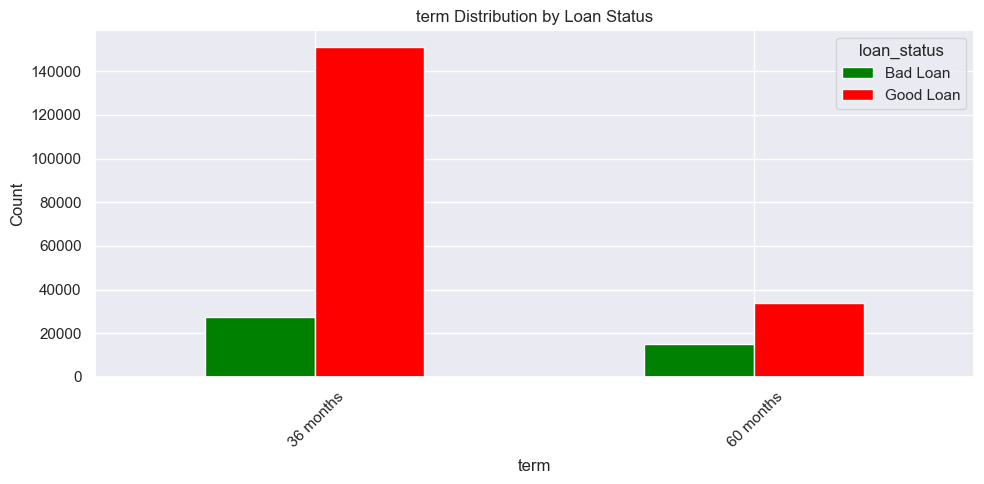


=== Categorical Feature: sub_grade vs loan_status ===


loan_status,Bad Loan,Good Loan
sub_grade,,
A1,180 (3.29%),5289 (96.71%)
A2,268 (4.7%),5436 (95.3%)
A3,387 (5.79%),6293 (94.21%)
A4,752 (7.33%),9507 (92.67%)
A5,940 (8.65%),9930 (91.35%)
B1,1164 (10.45%),9972 (89.55%)
B2,1543 (11.39%),12009 (88.61%)
B3,2190 (12.93%),14753 (87.07%)
B4,2239 (14.36%),13350 (85.64%)


<Figure size 800x500 with 0 Axes>

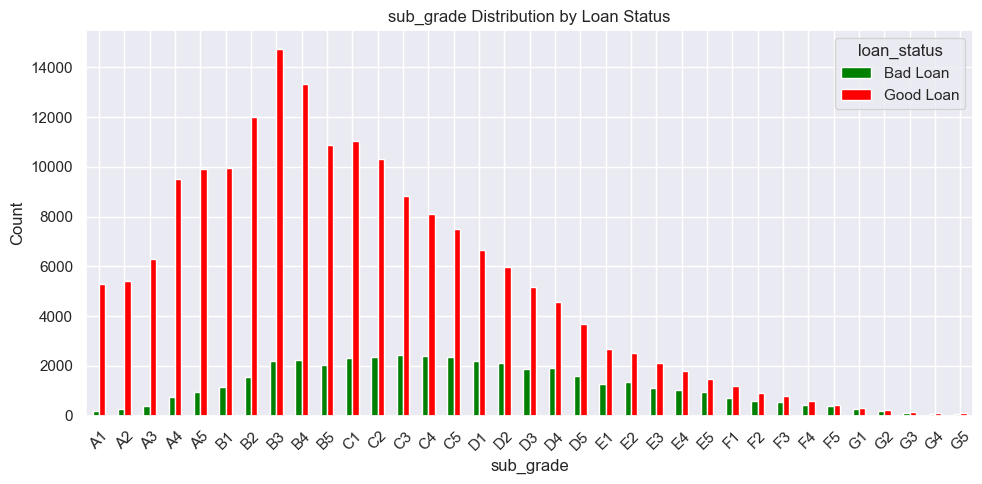


=== Categorical Feature: emp_length vs loan_status ===


loan_status,Bad Loan,Good Loan
emp_length,,
1 year,2727 (17.99%),12435 (82.01%)
10+ years,14677 (19.14%),62024 (80.86%)
2 years,3800 (17.89%),17439 (82.11%)
3 years,3335 (18.1%),15093 (81.9%)
4 years,2591 (17.63%),12102 (82.37%)
5 years,3034 (18.28%),13564 (81.72%)
6 years,2576 (18.86%),11083 (81.14%)
7 years,2465 (19.13%),10419 (80.87%)
8 years,2035 (19.31%),8502 (80.69%)


<Figure size 800x500 with 0 Axes>

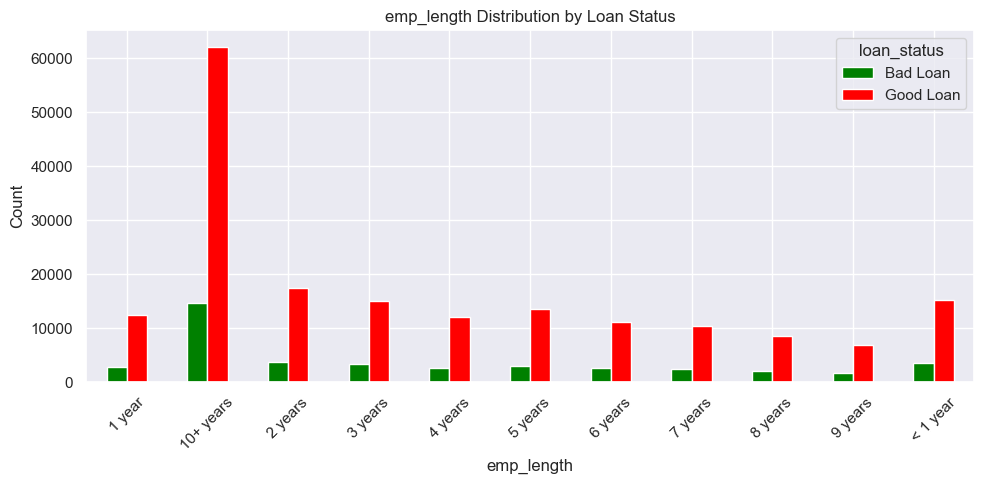


=== Categorical Feature: home_ownership vs loan_status ===


loan_status,Bad Loan,Good Loan
home_ownership,,
ANY,0 (0.0%),1 (100.0%)
MORTGAGE,18799 (16.78%),93221 (83.22%)
NONE,7 (16.28%),36 (83.72%)
OTHER,27 (19.15%),114 (80.85%)
OWN,3736 (19.58%),15342 (80.42%)
RENT,19906 (20.75%),76025 (79.25%)


<Figure size 800x500 with 0 Axes>

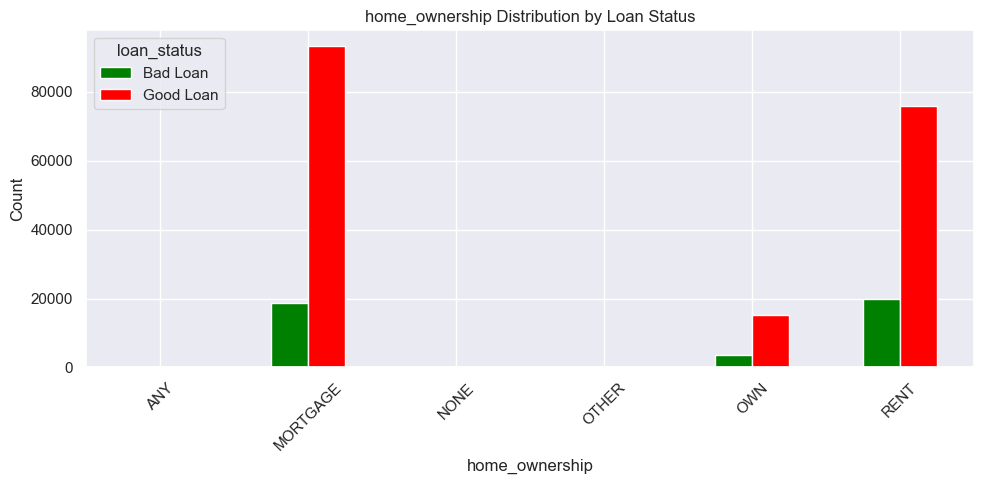


=== Categorical Feature: verification_status vs loan_status ===


loan_status,Bad Loan,Good Loan
verification_status,,
Not Verified,11624 (14.69%),67493 (85.31%)
Source Verified,12560 (19.83%),50773 (80.17%)
Verified,18291 (21.58%),66473 (78.42%)


<Figure size 800x500 with 0 Axes>

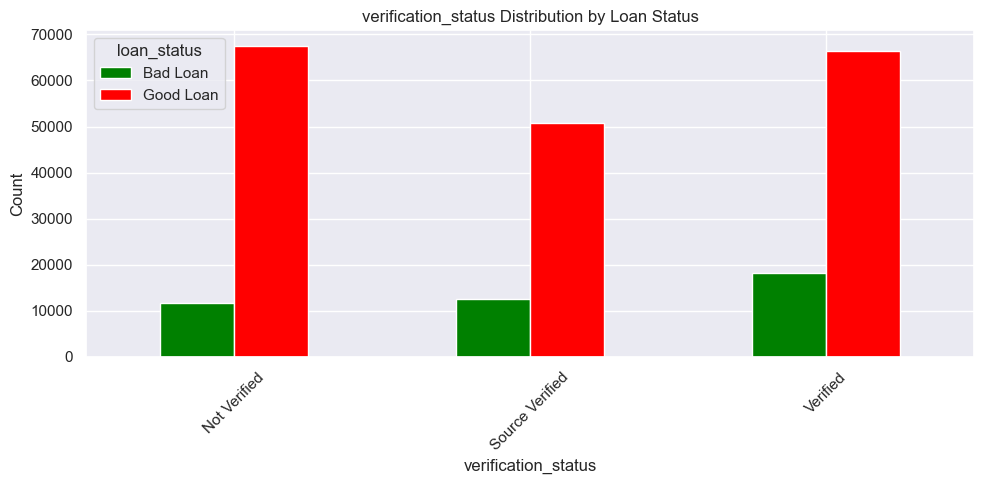


=== Categorical Feature: purpose vs loan_status ===


loan_status,Bad Loan,Good Loan
purpose,,
car,425 (12.53%),2966 (87.47%)
credit_card,7380 (16.2%),38169 (83.8%)
debt_consolidation,25835 (19.53%),106441 (80.47%)
educational,56 (17.23%),269 (82.77%)
home_improvement,2126 (16.1%),11076 (83.9%)
house,267 (18.43%),1182 (81.57%)
major_purchase,808 (14.13%),4912 (85.87%)
medical,523 (20.29%),2054 (79.71%)
moving,393 (21.87%),1404 (78.13%)


<Figure size 800x500 with 0 Axes>

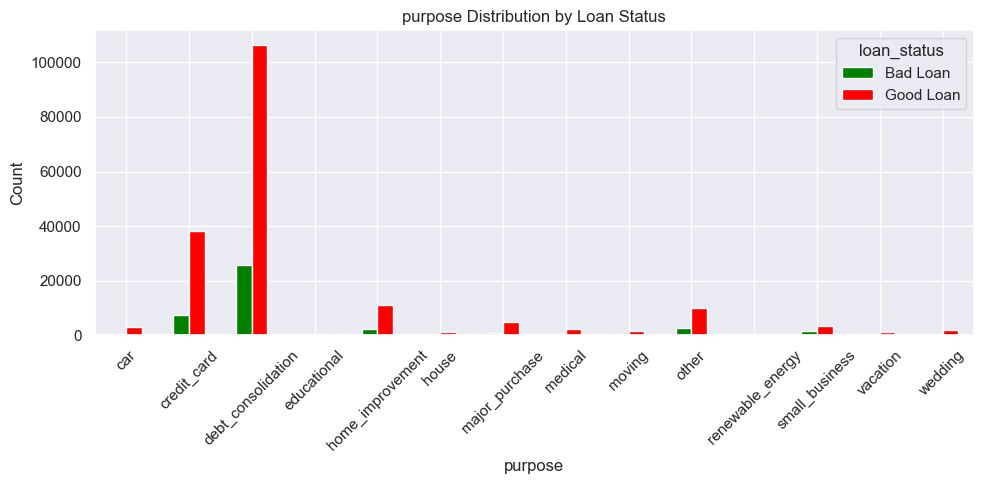


=== Categorical Feature: earliest_cr_line vs loan_status ===


loan_status,Bad Loan,Good Loan
earliest_cr_line,,
Apr-00,259 (19.88%),1044 (80.12%)
Apr-01,267 (22.44%),923 (77.56%)
Apr-02,219 (21.16%),816 (78.84%)
Apr-03,185 (20.9%),700 (79.1%)
Apr-04,182 (22.17%),639 (77.83%)
Apr-05,142 (21.52%),518 (78.48%)
Apr-06,136 (21.15%),507 (78.85%)
Apr-07,108 (21.3%),399 (78.7%)
Apr-08,76 (23.97%),241 (76.03%)


<Figure size 800x500 with 0 Axes>

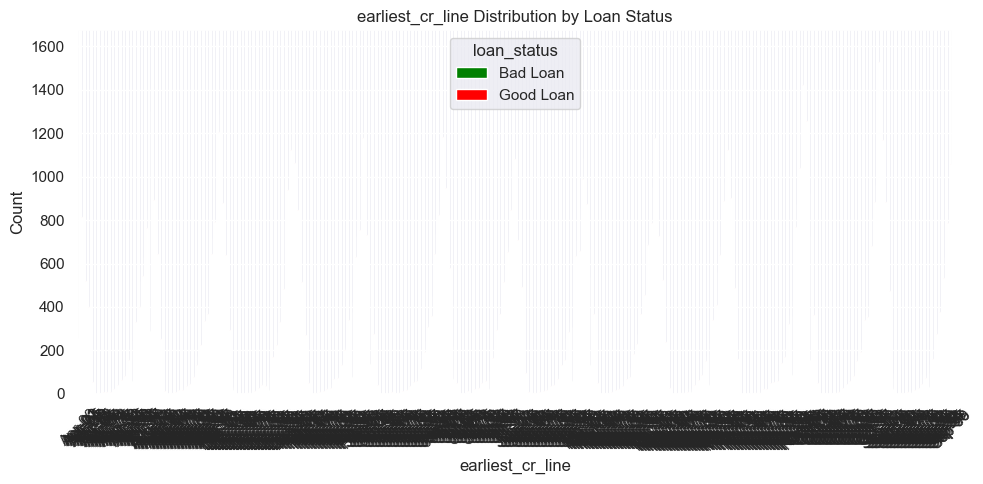

In [28]:
bivariate_analysis(df, target="loan_status")

# 3. Feature Engineering

- Feature transformation
- Feature Encoding
- Feature selection
- Scaling

## 3.1 Feature Transformation

Transforming categorical features to be numerical features.
- term
- earliest_cr_line

### 3.1.1 Feature: term

Converting the term value from 36 months or 60 months to be 36 or 60

In [23]:
#Convert feature term
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))
df['term'] = df['term'].astype(int)

### 3.1.2 Feature: earliest_cr_line  

Extracting the feature earliest_cr_line date for the year only with 4-digit year format

In [24]:
# Convert strings like "Jan-85" to proper datetime first
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')

# Extract the 4-digit year
df['earliest_cr_line'] = df['earliest_cr_line'].dt.year

## 3.2 Feature Encoding

Feature encoding:
- Label encoding
- One-hot encoding

### 3.2.1 Label Encoding:
- Feature: sub_grade
- Feature: emp_lenght
- Feature: verification_status

#### a. Feature: sub_grade

Label Encoding scale: A1 = 35 (the best) → G5 = 1 (the worst)

In [25]:
# Data Sub-Grade
sub_grades = [
    "A1", "A2", "A3", "A4", "A5",
    "B1", "B2", "B3", "B4", "B5",
    "C1", "C2", "C3", "C4", "C5",
    "D1", "D2", "D3", "D4", "D5",
    "E1", "E2", "E3", "E4", "E5",
    "F1", "F2", "F3", "F4", "F5",
    "G1", "G2", "G3", "G4", "G5"]

# Label Encoding
sub_grade_labels = {grade: i for i, grade in enumerate(reversed(sub_grades), start=1)}
df['sub_grade'] = df['sub_grade'].map(sub_grade_labels)

#### b. Feature: emp_lenght

Convert emp_lenght to be interger. 
- 0 and <1 year are considered 0
- 10+ years are considered 10
- the rest are the same

In [26]:
emp_length = {
    '0' : 0,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

# Mapping the new 'emp_lenght' into the dataset
df['emp_length'] = df['emp_length'].map(emp_length)

#### c. Feature: verification_status

Convert verification_status to interger with label encoding:
- Verified = 0
- Not Verified = 1
- Source Verified = 2

In [27]:
verification_status = {
    'Verified': 0,
    'Not Verified': 1,
    'Source Verified': 2
}

# Mapping the new 'verification_status' into the dataset
df['verification_status'] = df['verification_status'].map(verification_status)

### 3.2.2 One-Hot Encoding:
- Feature: home_ownership
- Feature: purpose

#### Feature: home_ownership

In [28]:
# Changing home_ownership to 4 categories
home_ownership = {
    'OTHER': 'OTHER',
    'NONE': 'OTHER',
    'ANY': 'OTHER'
}

# Mapping the new 'home_ownership' into the dataset
df['home_ownership'] = df['home_ownership'].replace(home_ownership)


#### One-Hot Encoding Feature: home_ownership & Feature: purpose

In [29]:
df = pd.get_dummies(df, columns=['home_ownership',
                                    'purpose'], drop_first=True)


## Final check on latest dataframe (df)

In [36]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,verification_status,loan_status,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,tot_cur_bal,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000,36,10.65,162.87,29,10,24000.0,0,Fully Paid,27.65,0.0,1985,3.0,0.0,13648,9.0,0.0,0.0,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
1,2500,60,15.27,59.83,22,0,30000.0,2,Charged Off,1.00,0.0,1999,3.0,0.0,1687,4.0,0.0,0.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2400,36,15.96,84.33,21,10,12252.0,1,Fully Paid,8.72,0.0,2001,2.0,0.0,2956,10.0,0.0,0.0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
3,10000,36,13.49,339.31,25,10,49200.0,2,Fully Paid,20.00,0.0,1996,10.0,0.0,5598,37.0,0.0,0.0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False
4,3000,60,12.69,67.79,26,1,80000.0,2,Current,17.94,0.0,1996,15.0,0.0,27783,38.0,0.0,0.0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  int64  
 1   term                        466285 non-null  int64  
 2   int_rate                    466285 non-null  float64
 3   installment                 466285 non-null  float64
 4   sub_grade                   466285 non-null  int64  
 5   emp_length                  466285 non-null  int64  
 6   annual_inc                  466285 non-null  float64
 7   verification_status         466285 non-null  int64  
 8   loan_status                 466285 non-null  object 
 9   dti                         466285 non-null  float64
 10  delinq_2yrs                 466285 non-null  float64
 11  earliest_cr_line            466285 non-null  int32  
 12  open_acc                    466285 non-null  float64
 13  pub_rec            

Categorical features have been transformed into numerical. Thus, all features are in numerical type now

## 3.3 Correlation

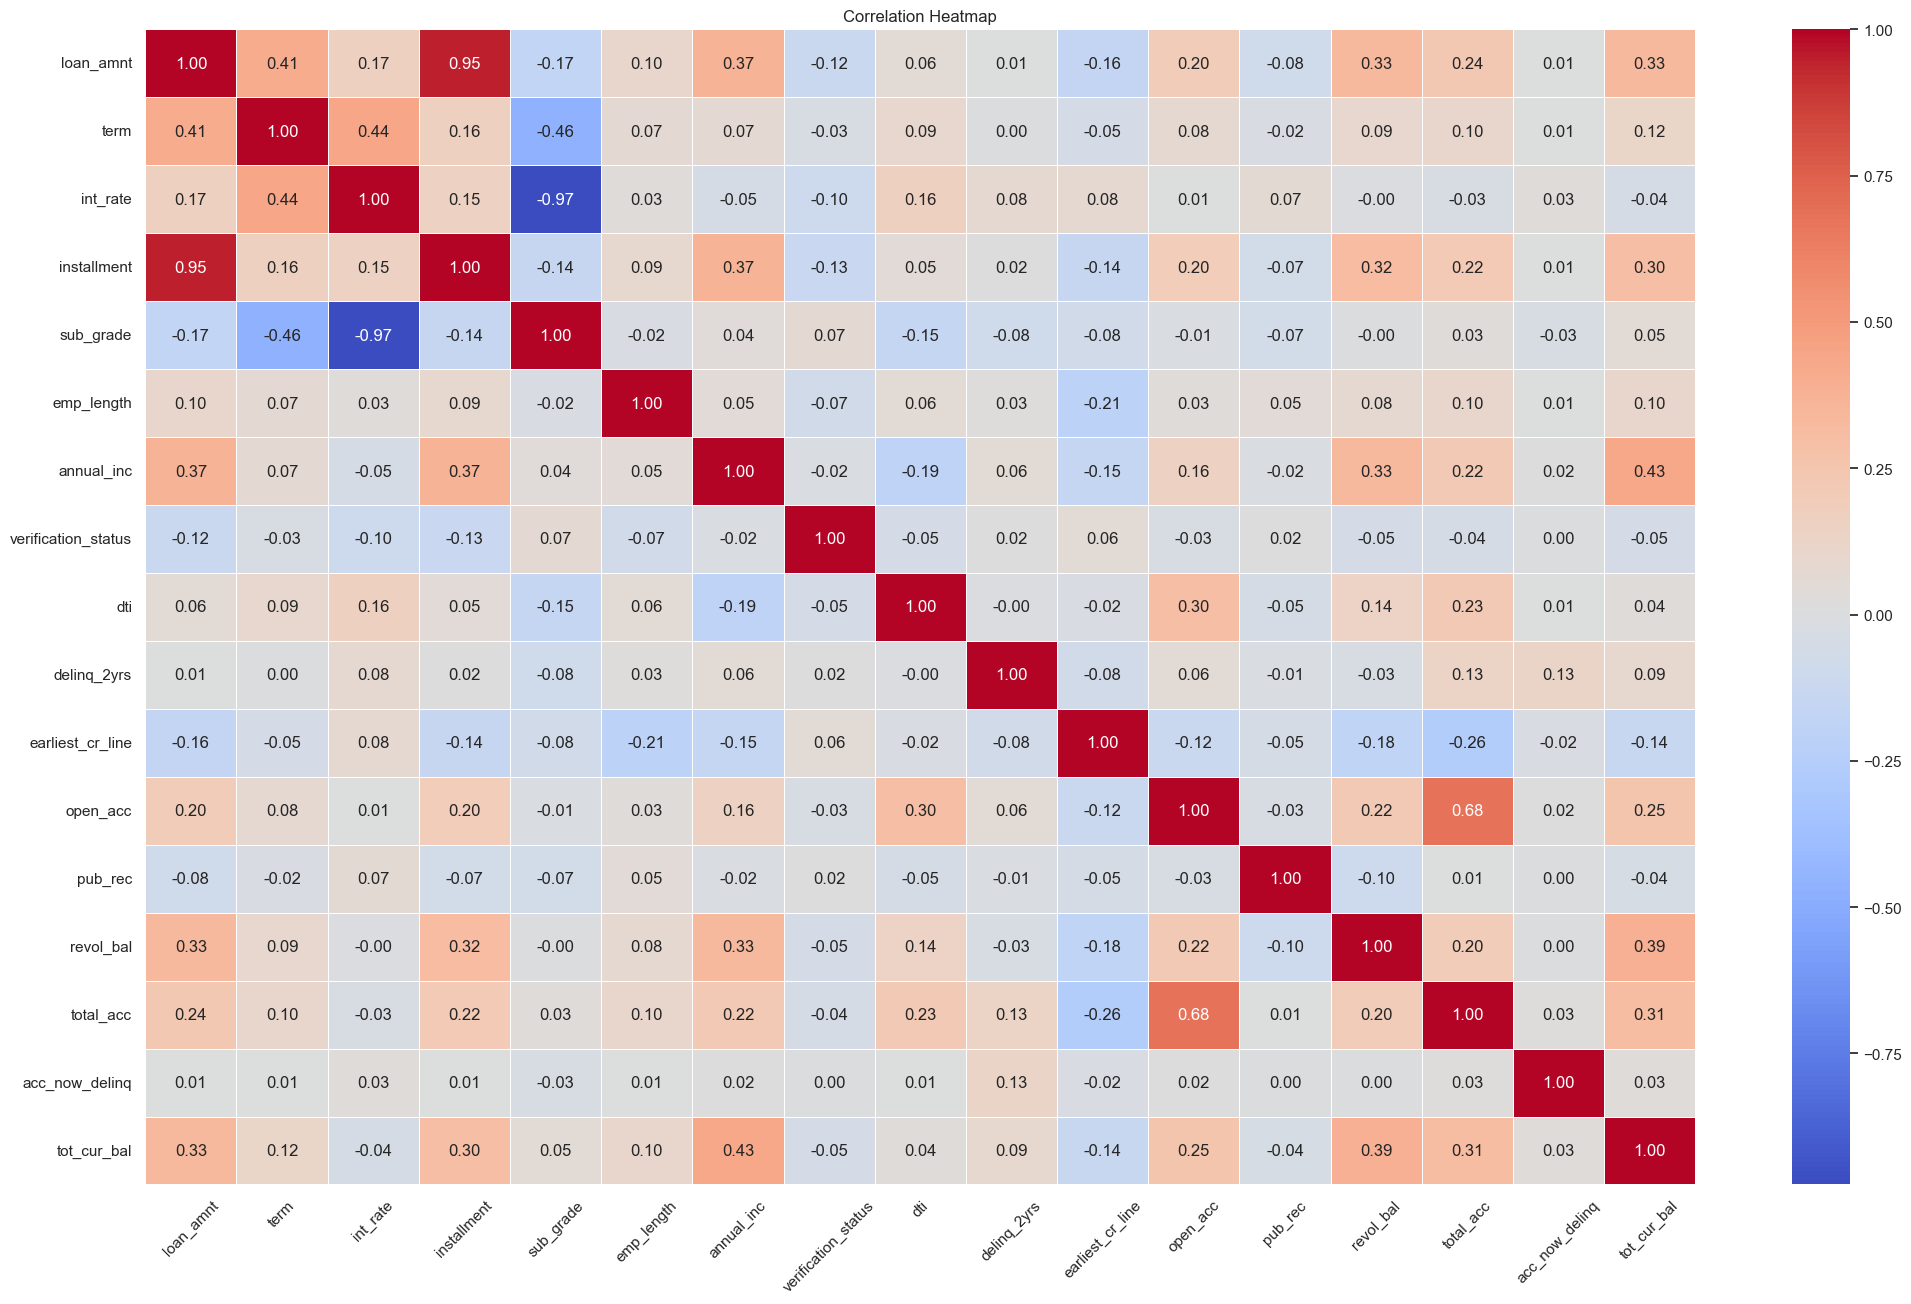

In [38]:
numerical_dataset = df.select_dtypes(include=['number'])
correlation_ = numerical_dataset.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(correlation_, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

The correlation hatmap shows that feature 'loan_amnt' and feature 'installment' have strong correlation (0.95). Thus, only one feature is needed, and feature 'installment' will be dropped.

## 3.4 TARGET FEATURE

In [30]:
# New Dataframe with values in loan_status only 'Fully Paid' and 'Charged Off'

loan_data= df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

#Mapping the target feature
loan_data['target'] = loan_data['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1,
})

In [31]:
loan_data.drop(columns= ['loan_status'], inplace = True)

In [41]:
loan_data['target'].value_counts()

target
0    184739
1     42475
Name: count, dtype: int64

In [32]:
# Separate Features & Target
X = loan_data.drop(columns=['target'])
y = loan_data['target']

## 3.5 Best Features

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [34]:
selector = SelectKBest(score_func=mutual_info_classif, k=20)  
X_new = selector.fit_transform(X, y)

In [45]:
scores = selector.scores_
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores
})

# Sort by highest score
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores)

                       Feature     Score
4                    sub_grade  0.032051
2                     int_rate  0.031234
21  purpose_debt_consolidation  0.029924
1                         term  0.029798
3                  installment  0.021154
19         home_ownership_RENT  0.019390
7          verification_status  0.016446
0                    loan_amnt  0.009684
5                   emp_length  0.007122
8                          dti  0.006797
20         purpose_credit_card  0.005059
6                   annual_inc  0.004427
16                 tot_cur_bal  0.003651
11                    open_acc  0.003591
10            earliest_cr_line  0.003059
14                   total_acc  0.002150
26             purpose_medical  0.001955
12                     pub_rec  0.001559
24               purpose_house  0.001279
30      purpose_small_business  0.001174
17        home_ownership_OTHER  0.001074
9                  delinq_2yrs  0.000952
29    purpose_renewable_energy  0.000909
15              

### Split Train and Test Dataset

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# 4. Modelling

In [47]:
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install imblearn

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, make_scorer,confusion_matrix,precision_recall_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

#XGB
import xgboost as xgb

import joblib

#hyperparameter
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, KFold, cross_val_score, cross_validate

from scipy.stats import uniform, randint

#import itertools
import itertools

### Definining Functions and Metrics

#### Evaluation Report

In [48]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Probabilities (only used for ROC-AUC)
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Get classification report
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    
 
    
    
    
    # Extracting metrics
    train_metrics = {
        "precision_0": report_train["0"]["precision"],
        "precision_1": report_train["1"]["precision"],
        "recall_0":   report_train["0"]["recall"],
        "recall_1":   report_train["1"]["recall"],
        "f1_0":   report_train["0"]["f1-score"],
        "f1_1":   report_train["1"]["f1-score"],
        "macro_avg_precision":  report_train["macro avg"]["precision"],
        "macro_avg_recall":   report_train["macro avg"]["recall"],
        "macro_avg_f1":   report_train["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_train, y_pred_train),
        "ROC-AUC": roc_auc_score(y_train, y_prob_train),
        "precision_recall": precision_recall_curve(y_train, y_prob_train)
        
    }


    test_metrics = {
        "precision_0": report_test["0"]["precision"],
        "precision_1": report_test["1"]["precision"],
        "recall_0":  report_test["0"]["recall"],
        "recall_1":  report_test["1"]["recall"],
        "f1_0":  report_test["0"]["f1-score"],
        "f1_1":  report_test["1"]["f1-score"],
        "macro_avg_precision":  report_test["macro avg"]["precision"],
        "macro_avg_recall":  report_test["macro avg"]["recall"],
        "macro_avg_f1":  report_test["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred_test),
        "ROC-AUC": roc_auc_score(y_test, y_prob_test),
        "precision_recall": precision_recall_curve(y_test, y_prob_test)
    }



    # Convert dictionary to dataframe
    metrics = pd.DataFrame([train_metrics,test_metrics],  index=["Train", "Test"])
    
    return metrics

#### Confusion Matrix

In [49]:
#confusion matrix function
def plot_confusion_matrix(c_matrix,
                          target_names,
                          title = 'Confusion Matrix',
                          cmap= None, 
                          normalize= True):
    
    #np.trace = sum of all the elements of a diagonal of given matrix
    accuracy = np.trace(c_matrix) / np.sum(c_matrix).astype('float')
    misclass = 1 - accuracy
    
    #get colormap instance
    if cmap is None:
        cmap = plt.get_cmap('coolwarm')
        
    #image size
    plt.figure(figsize=(8,6))
    
    #display data as an image
    #data is resampled to the pixel size of the image on the figure canvas 
    #'nearest' interpolation is used if the number of display pixels is at least three times the size of the data array
    plt.imshow(c_matrix, interpolation='nearest', cmap= cmap)
    
    plt.title(title)
    
    #add a colorbar to a plot
    plt.colorbar()
    
    #set tick locations
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    #percentage with normalize
    #np.newaxis increase the dimensions of an array by adding new axes.
    if normalize:
        c_matrix = c_matrix.astype('float') / c_matrix.sum(axis =1)[:, np.newaxis]
    
    #threshold
    threshold = c_matrix.max()/1 if normalize else c_matrix.max()/2
    
    #itertools.product returns the cartesian product of the input iterables
    #The Cartesian product is the set of all combinations of elements from multiple sets
    for i,j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(c_matrix[i,j]),
                     horizontalalignment = 'center',
                     color = 'white' if c_matrix[i,j] > threshold else 'black')
        else:
            plt.text(j, i, "{:,}".format(c_matrix[i,j]),
                     horizontalalignment = 'center',
                     color = 'white' if c_matrix[i,j] > threshold else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show() 

#### Hyperparameter Tuning Function

In [50]:
# Defining the function of hyperparameter tuning with RandomizedSearch

def tune_clf_hyperparameters_random(clf, param_distributions, X_train, y_train,
                                    scoring='recall', n_splits=3, n_iter=10, random_state=42):
    
    #cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv = 3

    clf_random = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1, 
        random_state=random_state,
        refit = 'recall'
    )

    clf_random.fit(X_train, y_train)
    best_hyperparameters = clf_random.best_params_
    return clf_random.best_estimator_, best_hyperparameters


## 4.1 Decision Tree

### 4.1.1 Model

In [51]:
# Define the base DT model
dt_base = DecisionTreeClassifier(class_weight='balanced',random_state=0)
dt_base.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


### 4.1.2 Hyperparameter Tuning with RandomizedSearch

In [52]:
# setting up the parameter options
param_dist_dt = {
    'max_depth': randint(0,5),
    'splitter': ['best'],
    'min_samples_split': randint(2, 5),
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': randint (1, 5)
}

In [53]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters_random(dt_base, param_dist_dt, X_train, y_train)

In [57]:
print('Decision Tree Optimal Hyperparameters: \n', best_dt_hyperparams)

Decision Tree Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 4, 'splitter': 'best'}


### 4.1.3 Decision Tree Evaluation

In [58]:
y_pred_train= best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)

print('Train Classification Report: \n',classification_report(y_train, y_pred_train))
print('Test Classification Report: \n',classification_report(y_test,y_pred_test ))

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.53      0.66    147757
           1       0.26      0.73      0.38     34014

    accuracy                           0.56    181771
   macro avg       0.58      0.63      0.52    181771
weighted avg       0.78      0.56      0.61    181771

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.53      0.66     36982
           1       0.26      0.72      0.38      8461

    accuracy                           0.56     45443
   macro avg       0.57      0.62      0.52     45443
weighted avg       0.77      0.56      0.61     45443



In [59]:
dt_evaluation = evaluate_model(best_dt, X_train, y_train, X_test, y_test)
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,ROC-AUC,precision_recall
Train,0.893641,0.261574,0.527305,0.727377,0.663250,0.384777,0.577608,0.627341,0.524014,0.564744,0.664506,"([0.18712555908258194, 0.2140364300191949, 0.2..."
Test,0.889984,0.257140,0.527392,0.715046,0.662309,0.378255,0.573562,0.621219,0.520282,0.562331,0.658214,"([0.18618929208018836, 0.21216198035786357, 0...."


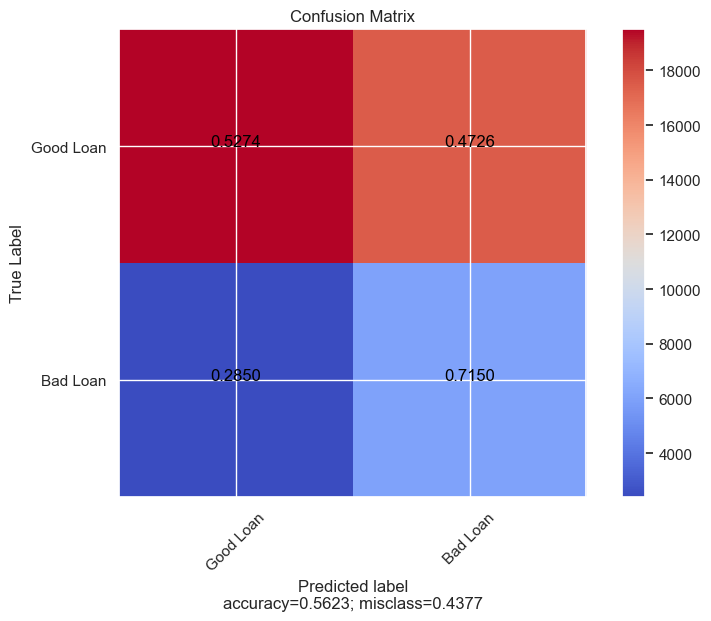

In [60]:
#Confusion matrix for test prediction

cm_dt = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(
    cm_dt,
    target_names=['Good Loan', 'Bad Loan'], 
    title='Confusion Matrix',
    normalize=True
)

## 4.2 Random Forest

### 4.2.1 Model

In [61]:
rf_base = RandomForestClassifier(class_weight = {0: 1, 1: 5}, random_state=0)
rf_base = rf_base.fit(X_train, y_train)
rf_base

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 4.2.2. Hyperparameter Tuning

In [62]:
param_dist_rf = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy', 'logloss'],
   'max_depth': randint(0,5),
    'min_samples_split':randint(2,5),
    'min_samples_leaf':randint(1,5),
    'bootstrap': [True, False],
}

In [63]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters_random(rf_base, param_dist_rf, X_train, y_train)


In [64]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 100}


### 4.2.3 Evaluation

In [65]:
y_pred_train= best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

print('Train Classification Report: \n',classification_report(y_train, y_pred_train))
print('Test Classification Report: \n',classification_report(y_test,y_pred_test ))

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.52      0.66    147757
           1       0.26      0.73      0.39     34014

    accuracy                           0.56    181771
   macro avg       0.58      0.63      0.52    181771
weighted avg       0.78      0.56      0.61    181771

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.52      0.66     36982
           1       0.26      0.72      0.38      8461

    accuracy                           0.56     45443
   macro avg       0.57      0.62      0.52     45443
weighted avg       0.77      0.56      0.61     45443



In [66]:
rf_evaluation = evaluate_model(best_rf, X_train, y_train, X_test, y_test)
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,ROC-AUC,precision_recall
Train,0.895088,0.261928,0.524584,0.732904,0.661489,0.385931,0.578508,0.628744,0.523710,0.563566,0.681337,"([0.18712555908258194, 0.18803707664094055, 0...."
Test,0.891216,0.257360,0.524580,0.720128,0.660426,0.379201,0.574288,0.622354,0.519813,0.560988,0.675133,"([0.18618929208018836, 0.18707317073170732, 0...."


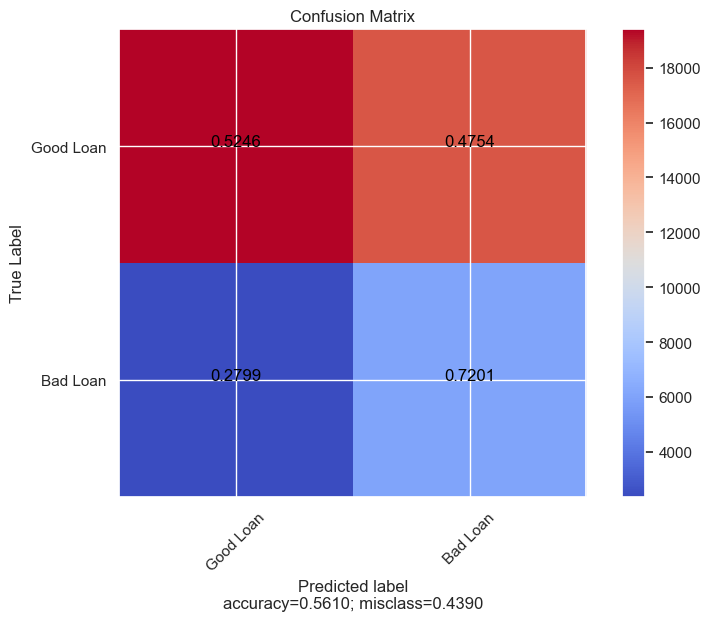

In [67]:
#Confusion matrix for test prediction

cm_rf = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(
    cm_rf,
    target_names=['Good Loan', 'Bad Loan'], 
    title='Confusion Matrix',
    normalize=True
)

## 4.3 XGBoost

In [68]:
# Defining the function of hyperparameter tuning with RandomizedSearch

def tune_clf_hyperparameters_random(clf, param_distributions, X_train, y_train,
                                    scoring='recall', n_splits=3, n_iter=20, random_state=42):
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
   

    clf_random = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1, 
        random_state=random_state,
        refit = 'roc',
        
    )

    clf_random.fit(X_train, y_train)
    best_hyperparameters = clf_random.best_params_
    return clf_random.best_estimator_, best_hyperparameters


### 4.3.1 Model

In [69]:
import xgboost as xgb
xgb_base = xgb.XGBClassifier(scale_pos_weight=4.3,
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42)
#xgb_base.fit(X_train, y_train)

### 4.3.2 Hyperparameter Tuning

In [70]:
xgb_param_dist = {
    'max_depth': randint(5,10),           # Range [3, 10)
    'learning_rate': uniform(0.01, 1),   # Range [0.01, 0.31)
    'n_estimators': randint(50, 200),
    'subsample': uniform(0.4, 1.5),
    'objective':['binary:logistic'], # Range [0.6, 1.0)
     'colsample_bytree': [0.3,0.6, 1.0]
    
}

In [71]:
# Hyperparameter tuning for XGB
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters_random(xgb_base, xgb_param_dist, X_train, y_train)


In [72]:
print('XGB Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGB Optimal Hyperparameters: 
 {'colsample_bytree': 0.3, 'learning_rate': np.float64(0.056450412719997727), 'max_depth': 7, 'n_estimators': 184, 'objective': 'binary:logistic', 'subsample': np.float64(0.6557861855309373)}


### 4.3.3 Evaluation

In [73]:
y_pred_train= best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print('Train Classification Report: \n',classification_report(y_train, y_pred_train))
print('Test Classification Report: \n',classification_report(y_test,y_pred_test ))

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.68      0.78    147757
           1       0.33      0.69      0.45     34014

    accuracy                           0.68    181771
   macro avg       0.62      0.69      0.61    181771
weighted avg       0.80      0.68      0.72    181771

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.67      0.76     36982
           1       0.30      0.64      0.41      8461

    accuracy                           0.66     45443
   macro avg       0.60      0.65      0.59     45443
weighted avg       0.78      0.66      0.70     45443



In [74]:
xgb_evaluation = evaluate_model(best_xgb, X_train, y_train, X_test, y_test)
xgb_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,ROC-AUC,precision_recall
Train,0.905951,0.332343,0.679183,0.693714,0.776346,0.449392,0.619147,0.686449,0.612869,0.681902,0.755086,"([0.18712555908258194, 0.18712658854596467, 0...."
Test,0.888893,0.303830,0.666730,0.635740,0.761947,0.411160,0.596361,0.651235,0.586554,0.660960,0.708595,"([0.18618929208018836, 0.18619338937546762, 0...."


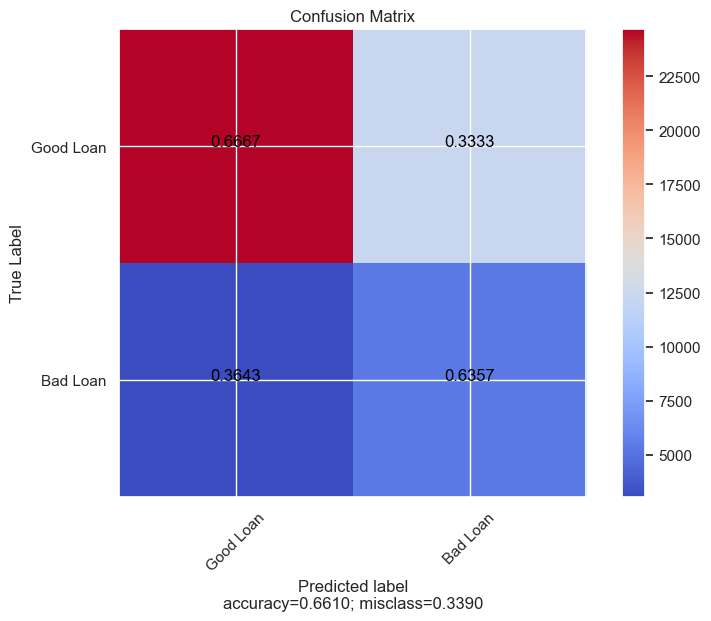

In [75]:
#Confusion matrix for test prediction

cm_xgb = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(
    cm_xgb,
    target_names=['Good Loan', 'Bad Loan'], 
    title='Confusion Matrix',
    normalize=True
)

## 4.4. Stacking

### 4.4.1 Model

#### Random Forest as Estimators

In [76]:
estimators =[('rf', RandomForestClassifier(
    class_weight= 'balanced', 
    criterion = 'gini',
    max_depth = 1,
    min_samples_split = 3,
    min_samples_leaf = 4,
    bootstrap = False,
))]

#### XGB as Final Estimator

In [77]:
final_estimator = xgb.XGBClassifier(scale_pos_weight=4.3,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    max_depth = 7,         
    learning_rate =  0.0564,  
    n_estimators= 184,
    subsample = 0.655786,
    objective= 'binary:logistic',
    colsample_bytree =  0.3)


#### Model Stacking

In [78]:
from sklearn.ensemble import  StackingClassifier
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator= final_estimator,
    passthrough=True,          
    n_jobs=-1,
)

In [79]:
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pipeline = Pipeline(steps=[
    #('scaler', RobustScaler()),    
    #('smote', SMOTE(random_state=42)),
    ('model', stack_model)
])

pipeline =pipeline.fit(X_train, y_train)
pipeline


,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,estimators,"[('rf', ...)]"
,final_estimator,"XGBClassifier...ree=None, ...)"
,cv,None
,stack_method,'auto'
,n_jobs,-1
,passthrough,True
,verbose,0


### 4.4.2 Evaluation

In [80]:
y_pred_test = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

print("Train Classification Report:\n", classification_report(y_train, y_pred_train))
print("Test Classification Report:\n", classification_report(y_test, y_pred_test))

Train Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78    147757
           1       0.33      0.68      0.44     34014

    accuracy                           0.68    181771
   macro avg       0.62      0.68      0.61    181771
weighted avg       0.80      0.68      0.72    181771

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.67      0.77     36982
           1       0.30      0.63      0.41      8461

    accuracy                           0.66     45443
   macro avg       0.60      0.65      0.59     45443
weighted avg       0.78      0.66      0.70     45443



In [81]:
pp_evaluation = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
pp_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy,ROC-AUC,precision_recall
Train,0.901997,0.331336,0.685808,0.676310,0.779185,0.444771,0.616666,0.681059,0.611978,0.684031,0.747903,"([0.18712555908258194, 0.18712658854596467, 0...."
Test,0.887475,0.304955,0.673057,0.626994,0.765535,0.410334,0.596215,0.650026,0.587935,0.664481,0.708162,"([0.18618929208018836, 0.18619338937546762, 0...."


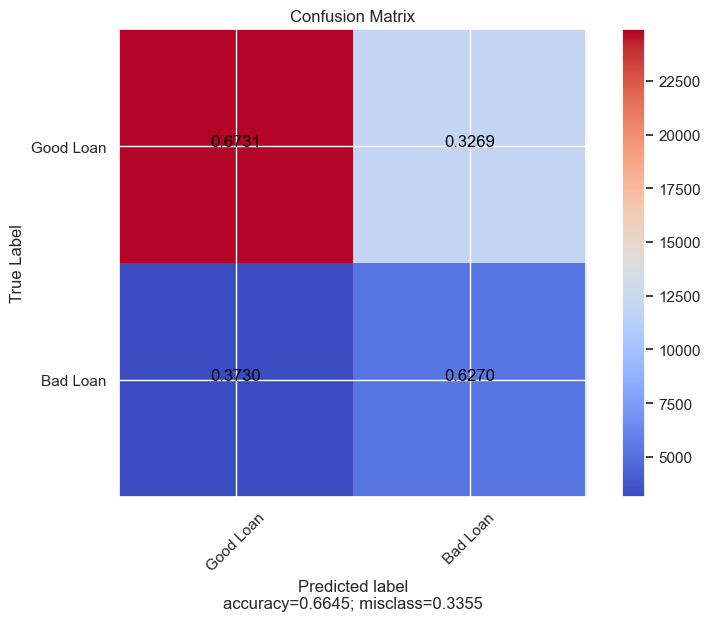

In [82]:
#Confusion matrix for test prediction

cm_pp = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(
    cm_pp,
    target_names=['Good Loan', 'Bad Loan'], 
    title='Confusion Matrix',
    normalize=True
)

# Model Comparison

In [83]:
comparison_df_train = pd.concat(
    [dt_evaluation, rf_evaluation, xgb_evaluation, pp_evaluation],
    keys=["Decision Tree", "Random Forest", "XGBoost", "STacking Random Forest & XGB"]
)

In [84]:
comparison_df_train

precision_0  precision_1  recall_0  \
Decision Tree                Train     0.893641     0.261574  0.527305   
                             Test      0.889984     0.257140  0.527392   
Random Forest                Train     0.895088     0.261928  0.524584   
                             Test      0.891216     0.257360  0.524580   
XGBoost                      Train     0.905951     0.332343  0.679183   
                             Test      0.888893     0.303830  0.666730   
STacking Random Forest & XGB Train     0.901997     0.331336  0.685808   
                             Test      0.887475     0.304955  0.673057   

                                    recall_1      f1_0      f1_1  \
Decision Tree                Train  0.727377  0.663250  0.384777   
                             Test   0.715046  0.662309  0.378255   
Random Forest                Train  0.732904  0.661489  0.385931   
                             Test   0.720128  0.660426  0.379201   
XGBoost                      Train  0.693714  0.776346  0.449392   
                             Test   0.635740  0.761947  0.411160   
STacking Random Forest & XGB Train  0.676310  0.779185  0.444771   
                             Test   0.626994  0.765535  0.410334   

                                    macro_avg_precision  macro_avg_recall  \
Decision Tree                Train             0.577608          0.627341   
                             Test              0.573562          0.621219   
Random Forest                Train             0.578508          0.628744   
                             Test              0.574288          0.622354   
XGBoost                      Train             0.619147          0.686449   
                             Test              0.596361          0.651235   
STacking Random Forest & XGB Train             0.616666          0.681059   
                             Test              0.596215          0.650026   

                                    macro_avg_f1  accuracy   ROC-AUC  \
Decision Tree                Train      0.524014  0.564744  0.664506   
                             Test       0.520282  0.562331  0.658214   
Random Forest                Train      0.523710  0.563566  0.681337   
                             Test       0.519813  0.560988  0.675133   
XGBoost                      Train      0.612869  0.681902  0.755086   
                             Test       0.586554  0.660960  0.708595   
STacking Random Forest & XGB Train      0.611978  0.684031  0.747903   
                             Test       0.587935  0.664481  0.708162   

                                                                     precision_recall  
Decision Tree                Train  ([0.18712555908258194, 0.2140364300191949, 0.2...  
                             Test   ([0.18618929208018836, 0.21216198035786357, 0....  
Random Forest                Train  ([0.18712555908258194, 0.18803707664094055, 0....  
                             Test   ([0.18618929208018836, 0.18707317073170732, 0....  
XGBoost                      Train  ([0.18712555908258194, 0.18712658854596467, 0....  
                             Test   ([0.18618929208018836, 0.18619338937546762, 0....  
STacking Random Forest & XGB Train  ([0.18712555908258194, 0.18712658854596467, 0....  
                             Test   ([0.18618929208018836, 0.18619338937546762, 0....

# 5. Deployment

## 5.1 Pickling the Model file for Deployment

In [85]:
import pickle

In [87]:
pickle.dump(best_dt, open('loanmodel.pkl', 'wb'))

In [88]:
pickled_model = pickle.load(open('loanmodel.pkl', 'rb'))